# Imports

In [ ]:
import os, re, glob, json
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, butter, cheby1, filtfilt
from scipy.interpolate import UnivariateSpline
from math import sqrt
import seaborn as sns
from scipy.ndimage import uniform_filter1d, median_filter
from scipy.signal   import correlate
from scipy.stats    import ks_2samp
from scipy.stats import wasserstein_distance, energy_distance
from scipy.spatial.distance import jensenshannon
from tqdm import tqdm
from functools import lru_cache

from feature_extraction import features_wrist_block, features_ankle_block, features_elbow_block, features_knee_block
from feature_computation import vel, acc, cross_corr, signal_entropy, iqr_stat, median_position, median_velocity 
from feature_computation import angle, angular_vel,  angular_acc
from feature_extraction import all_features_for_session
from utils import disp_metrics, peak_lag, se, mean_sq_jerk, min_jerk_1d, jerk, msj, part_confidence, lagged_disp

In [ ]:
from constants import FPS, SEC, JOINTS, MAX_GAP, MAX_LAG_FR, MAX_LAG_SEC, WINDOW_FR, WINDOW_SEC, dt
from constants import CONF_TH, SIGMA, WIN      
from constants import SCORE_COLS, XY_COLS

# Reading the JSON files

In [171]:
FOLDER = r"C:\Users\ioana\OneDrive\Desktop\annotations"     
N_FILES = 18 #187 total                              
name_re = re.compile(
    r"(?P<date>\d{4}_\d{2}_\d{2})_"      # 2021_07_26
    r"\d+_"                              # recording number we ignore (833180)
    r"(?P<participant>\d+)_"             # 201
    r"cam(?P<cam>\d+)_vid\d+\.json$"     # cam3
)

In [172]:
rows = []
for path in sorted(glob.glob(os.path.join(FOLDER, "*.json")))[:N_FILES]:
    m = name_re.search(os.path.basename(path))
    if not m:
        print(f" Skipped (name format?): {path}")
        continue
    
    date       = pd.to_datetime(m.group("date"), format="%Y_%m_%d")
    participant= int(m.group("participant"))
    camera     = int(m.group("cam"))
    
    with open(path, "r") as f:
        frames = json.load(f)          # top level = list of frames
    
    for frame in frames:
        fid = frame["frame_id"]
        for inst_i, inst in enumerate(frame["instances"]):
            kps     = inst["keypoints"]        # list[[x,y], …] length 17
            kp_s    = inst["keypoint_scores"]  # list[score]  length 17
            
            # Flatten keypoints so every (x,y,score) gets its own column
            record = {
                "date"          : date,
                "camera"        : camera,
                "participant_id": participant,
                "frame_id"      : fid,
                "instance_idx"  : inst_i,
            }
            for i, (xy, sc) in enumerate(zip(kps, kp_s)):
                record[f"x{i}"]     = xy[0]
                record[f"y{i}"]     = xy[1]
                record[f"score{i}"] = sc
            rows.append(record)

In [173]:
df = pd.DataFrame(rows)

In [174]:
df.head()

date  camera  participant_id  frame_id  instance_idx          x0  \
0 2021-07-26       3             201         0             0  361.027242   
1 2021-07-26       3             201         0             1  804.504721   
2 2021-07-26       3             201         0             2  822.541713   
3 2021-07-26       3             201         0             3  806.213967   
4 2021-07-26       3             201         1             0  360.278843   

            y0    score0          x1           y1  ...   score13          x14  \
0   667.847929  0.920992  339.677817   678.178145  ...  0.985141   790.259357   
1  1868.637342  0.257770  810.447079  1866.809957  ...  0.748712  1074.342156   
2  1871.110857  0.596883  841.598718  1877.882258  ...  0.242272   321.221966   
3  1892.929661  0.100071  795.759942  1885.918862  ...  0.694224   839.971939   
4   668.007866  0.931771  338.452149   679.163287  ...  0.982250   793.741293   

           y14   score14          x15          y15   score15          x16  \
0   923.892419  0.950637   892.392309   667.571038  0.969989   882.349755   
1  1617.537629  0.584149  1018.423242  1866.561995  0.088156  1064.025339   
2  1871.953478  0.390355   144.518203  1896.295941  0.961632   280.470757   
3  1859.068609  0.642309   823.505486  1889.627250  0.179076   840.940509   
4   925.141581  0.957903   894.766242   668.896053  0.952610   885.131452   

           y16   score16  
0   894.508950  0.910822  
1  1629.099040  0.266310  
2  1905.495459  0.915473  
3  1904.022024  0.143290  
4   890.948337  0.933250  

[5 rows x 56 columns]

In [175]:
# 0) compute mean score -------------------------------------------------
score_cols = [c for c in df.columns if c.startswith("score")]
df["mean_score"] = df[score_cols].mean(axis=1)

# 1) choose the highest-quality instance per unique frame --------------
best_idx = (
    df.groupby(["date", "participant_id", "camera", "frame_id"])
      ["mean_score"]
      .idxmax()                      # row-label of the top-scoring instance
)

keepers = (
    df.loc[best_idx]                 # pull those rows out of the big DF
      .sort_values(                  # 2) put them back in chronological order
          ["date", "participant_id", "camera", "frame_id"],
          ascending=[True, True, True, True]
      )
      .reset_index(drop=True)
)

print(keepers.head())

        date  camera  participant_id  frame_id  instance_idx          x0  \
0 2021-07-26       3             201         0             0  361.027242   
1 2021-07-26       3             201         1             0  360.278843   
2 2021-07-26       3             201         2             0  361.083892   
3 2021-07-26       3             201         3             0  362.031812   
4 2021-07-26       3             201         4             0  360.686736   

           y0    score0          x1          y1  ...         x14         y14  \
0  667.847929  0.920992  339.677817  678.178145  ...  790.259357  923.892419   
1  668.007866  0.931771  338.452149  679.163287  ...  793.741293  925.141581   
2  666.328148  0.929269  340.329540  676.496263  ...  793.771664  925.053525   
3  665.457730  0.929338  340.455224  676.332937  ...  794.021854  924.631746   
4  665.324786  0.919933  339.106871  676.612846  ...  796.034762  924.224804   

    score14         x15         y15   score15         x16     

In [176]:
summary = (
    keepers
      .groupby(["date", "participant_id"])
      .agg(n_frames=("frame_id", "nunique"))   # count unique frames
      .reset_index()
      .sort_values(["date", "participant_id"])
)

print("\nFrames kept per participant & date:")
print(summary.to_string(index=False))


Frames kept per participant & date:
      date  participant_id  n_frames
2021-07-26             201      8410
2021-08-17             202      3687
2021-08-19             201      7481
2021-09-09             202      9206
2021-09-15             203      7501
2021-09-16             201      7486
2021-10-01             202      4060
2021-10-06             203      7717
2021-10-07             201      7529
2021-11-05             203      7493
2021-11-11             201      7538
2021-12-10             202      7831
2021-12-15             204      7525
2021-12-16             201      7658
2022-01-12             202      7652
2022-01-12             204      7616
2022-02-04             203      7573
2022-02-14             207      7574


Interpolate the keypoints with confidence less than 0.1 (like in Robust and Interpretable General Movement
Assessment Using Fidgety Movement Detection
)

In [ ]:
from preprocessing_utils import interpolate_track

In [179]:
keepers_interp = (
    keepers
      .groupby(["participant_id", "date", "camera"], group_keys=False)
      .apply(interpolate_track)
)

# ── everything below stays the same ────────────────────────────
MIN_FRAMES = 1_000

counts = (keepers_interp
          .groupby(["participant_id", "date", "camera"])
          .size()
          .rename("n_frames"))

good_sessions = counts[counts >= MIN_FRAMES].index

keepers_long = (
    keepers_interp
      .set_index(["participant_id", "date", "camera"])
      .loc[good_sessions]
      .reset_index()
)

C:\Users\ioana\AppData\Local\Temp\ipykernel_25896\3455364051.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(interpolate_track)


In [200]:
# remove na row form keeprs long
keepers_long = keepers_long.dropna(subset=XY_COLS)
keepers_long

participant_id       date  camera  frame_id  instance_idx          x0  \
0                  201 2021-07-26       3         0             0  361.027242   
1                  201 2021-07-26       3         1             0  360.278843   
2                  201 2021-07-26       3         2             0  361.083892   
3                  201 2021-07-26       3         3             0  362.031812   
4                  201 2021-07-26       3         4             0  360.686736   
...                ...        ...     ...       ...           ...         ...   
131532             207 2022-02-14       3      7569             1  945.447179   
131533             207 2022-02-14       3      7570             1  947.216111   
131534             207 2022-02-14       3      7571             1  950.041573   
131535             207 2022-02-14       3      7572             1  951.393318   
131536             207 2022-02-14       3      7573             1  949.280915   

                 y0    score0          x1           y1  ...         x14  \
0        667.847929  0.920992  339.677817   678.178145  ...  790.259357   
1        668.007866  0.931771  338.452149   679.163287  ...  793.741293   
2        666.328148  0.929269  340.329540   676.496263  ...  793.771664   
3        665.457730  0.929338  340.455224   676.332937  ...  794.021854   
4        665.324786  0.919933  339.106871   676.612846  ...  796.034762   
...             ...       ...         ...          ...  ...         ...   
131532  1000.838336  0.991122  962.456878  1034.454111  ...  466.137360   
131533   998.416378  0.985216  962.764188  1033.248044  ...  472.488674   
131534   997.734302  0.988990  963.967088  1031.698849  ...  464.070752   
131535   997.823067  0.974028  964.144012  1032.190627  ...  465.390641   
131536   998.012986  0.986301  964.335579  1032.219243  ...  467.696933   

               y14   score14         x15          y15   score15         x16  \
0       923.892419  0.950637  892.392309   667.571038  0.969989  882.349755   
1       925.141581  0.957903  894.766242   668.896053  0.952610  885.131452   
2       925.053525  0.951839  895.143201   666.911500  0.943813  880.495490   
3       924.631746  0.952851  896.068243   667.004500  0.939086  881.935661   
4       924.224804  0.925136  899.272541   669.322768  0.939291  878.945773   
...            ...       ...         ...          ...       ...         ...   
131532  932.380359  0.835029  378.724823  1055.687369  0.618273  322.162976   
131533  930.243793  0.866839  373.887486  1049.495454  0.648824  322.931658   
131534  926.320857  0.888607  348.958249  1050.469384  0.620551  319.172360   
131535  924.160982  0.841710  336.244029  1029.278885  0.627634  324.358745   
131536  920.697347  0.869021  326.573679  1018.289831  0.620703  324.944102   

               y16   score16  mean_score  
0       894.508950  0.910822    0.907676  
1       890.948337  0.933250    0.912949  
2       891.889313  0.911516    0.909255  
3       889.416794  0.923034    0.908262  
4       889.556496  0.911612    0.905861  
...            ...       ...         ...  
131532  966.689019  0.810338    0.883290  
131533  954.407859  0.832625    0.874356  
131534  950.115772  0.819567    0.879124  
131535  923.099042  0.772547    0.869750  
131536  924.161066  0.795262    0.873816  

[131535 rows x 57 columns]

In [180]:
print(f"Dropped {len(keepers) - len(keepers_long)} rows "
      f"from {len(counts) - len(good_sessions)} recordings "
      f"(< {MIN_FRAMES} frames)")

Dropped 0 rows from 0 recordings (< 1000 frames)


In [ ]:
df.to_parquet("infant_keypoints_20files.parquet")

# Smoothing

Confidence-weighted Gaussian smoothing (σ=2, win=5) - as in "Robust and Interpretable General Movement
Assessment Using Fidgety Movement Detection"

In [ ]:
from filters import gauss_conf_weighted_1d, gauss_smooth

Participant 201, date 2021-07-26, camera 3
Frames analysed: 8410
Mean-squared jerk (raw)        :   1.86e+10
Mean-squared jerk (Gaussian σ=2):   3.42e+07


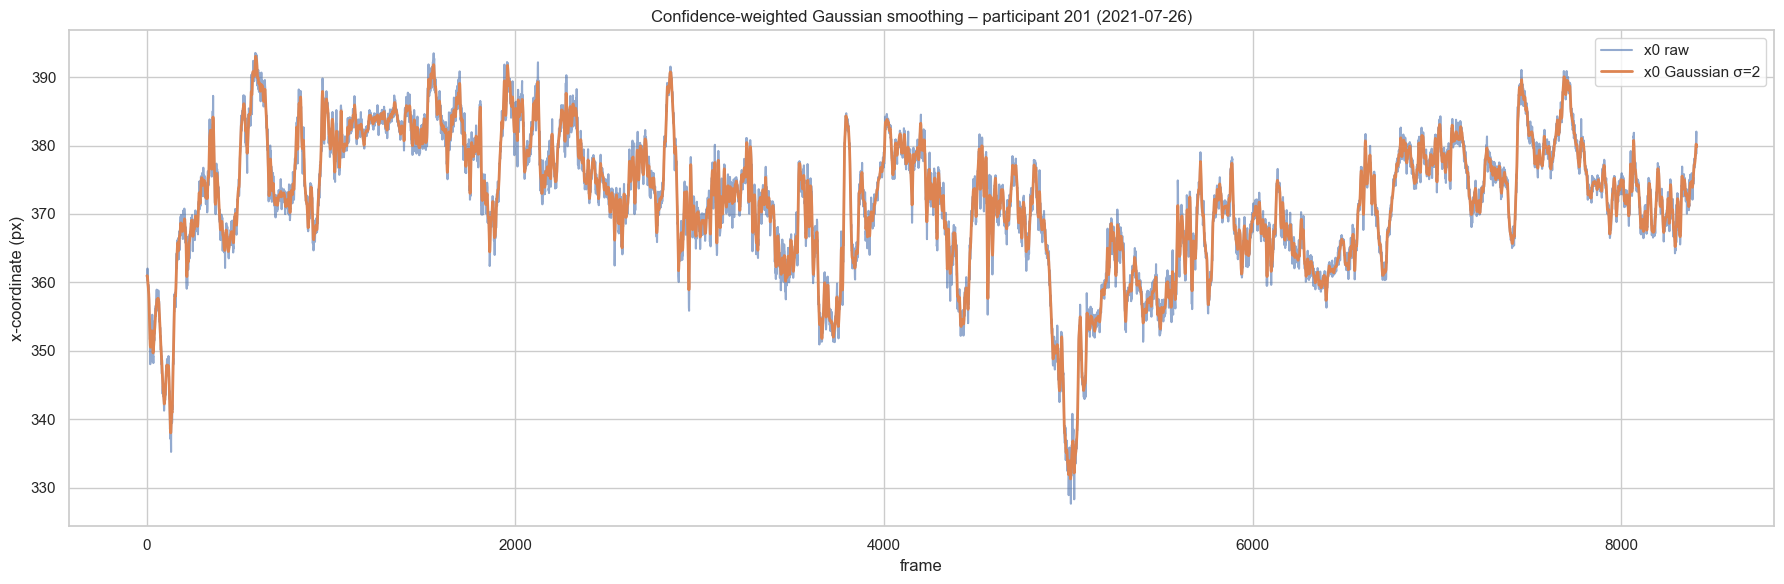

In [ ]:
first_row = df.iloc[0]
pid, date, cam = first_row["participant_id"], first_row["date"], first_row["camera"]

traj = (keepers[(keepers["participant_id"] == pid) &
                (keepers["date"] == date) &
                (keepers["camera"] == cam)]
        .sort_values("frame_id")
        .reset_index(drop=True))

# key-point 0
x_raw = traj["x0"].to_numpy()
y_raw = traj["y0"].to_numpy()
c_raw = traj["score0"].to_numpy()      # confidence

# ----- apply confidence-weighted Gaussian -------------------------
x_smooth = gauss_conf_weighted_1d(x_raw, c_raw)
y_smooth = gauss_conf_weighted_1d(y_raw, c_raw)

# ----- jerk metrics ------------------------------------------------
msj_raw   = mean_sq_jerk(x_raw) + mean_sq_jerk(y_raw)
msj_gauss = mean_sq_jerk(x_smooth) + mean_sq_jerk(y_smooth)

print(f"Participant {pid}, date {date.date()}, camera {cam}")
print(f"Frames analysed: {len(traj)}")
print(f"Mean-squared jerk (raw)        : {msj_raw:10.2e}")
print(f"Mean-squared jerk (Gaussian σ=2): {msj_gauss:10.2e}")

# ----- plot --------------------------------------------------------
plt.figure(figsize=(18,6))
plt.plot(traj["frame_id"], x_raw,    label="x0 raw",  alpha=0.6)
plt.plot(traj["frame_id"], x_smooth, label="x0 Gaussian σ=2", linewidth=2)
plt.xlabel("frame")
plt.ylabel("x-coordinate (px)")
plt.title(f"Confidence-weighted Gaussian smoothing – participant {pid} ({date.date()})")
plt.legend()
plt.tight_layout()


Minimum-jerk (MJ) reconstruction - Solve argmin Σ‖x‴(t)‖² subject to passing through observed points within tolerance (benchmark)

Participant 201, date 2021-07-26, camera 3
Frames analysed: 8410
Mean‑squared jerk (raw)    :   1.86e+10
Mean‑squared jerk (min‑jerk smoothed):   7.72e+04


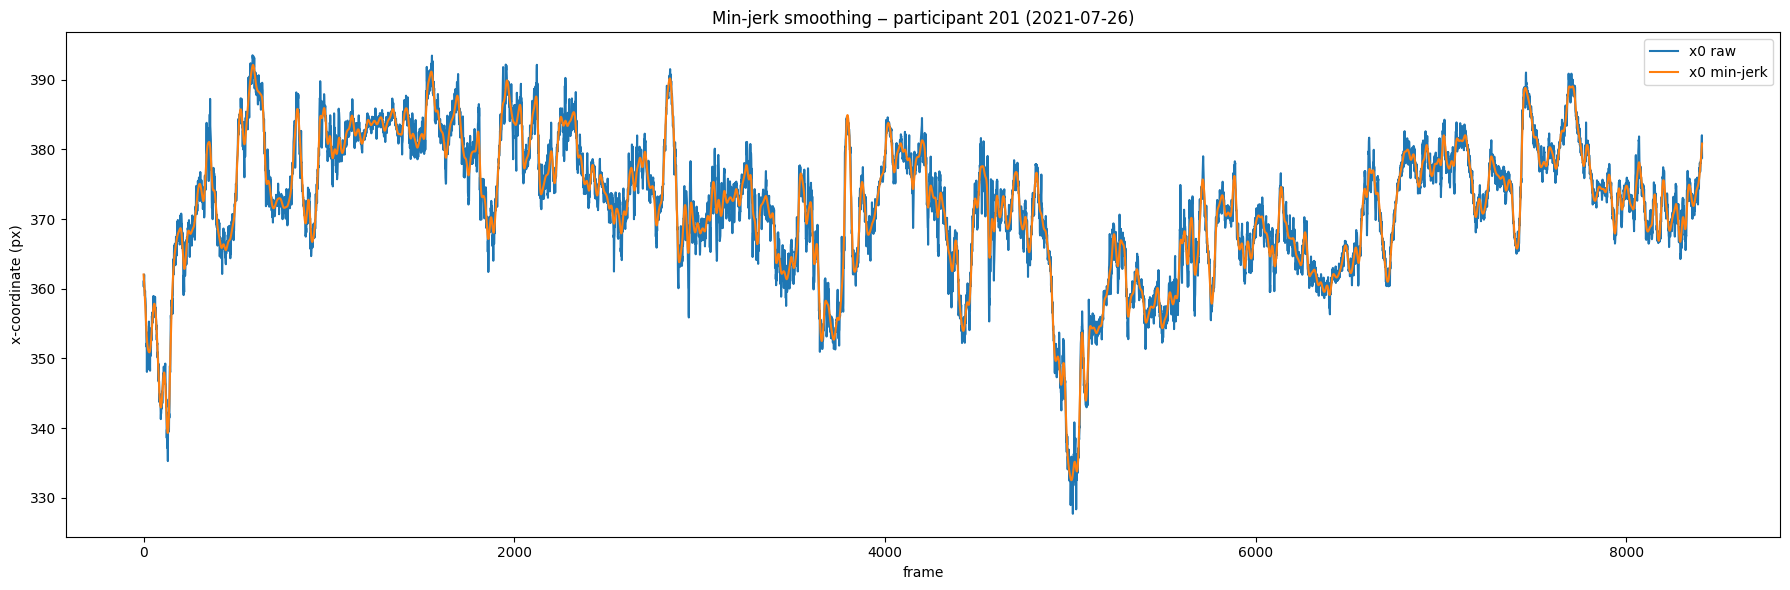

In [ ]:
try:
    first_row = keepers.iloc[0]
except NameError:
    raise RuntimeError("The DataFrame `keepers` is not in scope. "
                       "Run the previous steps first.")

pid   = first_row["participant_id"]
date  = first_row["date"]
cam   = first_row["camera"]

traj = (keepers[(keepers["participant_id"] == pid) &
                (keepers["date"] == date) &
                (keepers["camera"] == cam)]
        .sort_values("frame_id")
        .reset_index(drop=True))

#  use key‑point 0 (x0, y0) as demo
x_raw = traj["x0"].to_numpy()
y_raw = traj["y0"].to_numpy()

# smooth each coordinate
lam = 1e4                        # tweak if too stiff / too loose
x_smooth = min_jerk_1d(x_raw, lam)
y_smooth = min_jerk_1d(y_raw, lam)

# ---------- jerk (3rd derivative) metrics ----------
msj_raw    = mean_sq_jerk(x_raw) + mean_sq_jerk(y_raw)
msj_smooth = mean_sq_jerk(x_smooth) + mean_sq_jerk(y_smooth)

print(f"Participant {pid}, date {date.date()}, camera {cam}")
print(f"Frames analysed: {len(traj)}")
print(f"Mean‑squared jerk (raw)    : {msj_raw:10.2e}")
print(f"Mean‑squared jerk (min‑jerk smoothed): {msj_smooth:10.2e}")

# ---------- plot ----------
plt.figure(figsize=(18, 6))
plt.plot(traj["frame_id"], x_raw, label="x0 raw")
plt.plot(traj["frame_id"], x_smooth, label="x0 min‑jerk")
plt.xlabel("frame")
plt.ylabel("x‑coordinate (px)")
plt.title(f"Min‑jerk smoothing ‒ participant {pid} ({date.date()})")
plt.legend()
plt.tight_layout()

Savitzky–Golay (SG) filter – fits a low-order poly in a sliding window and returns the centre point

Participant 201, date 2021-07-26, camera 3
Frames analysed: 8410
Mean‑squared jerk (raw)              :   1.86e+10
Mean‑squared jerk (Savitzky–Golay)   :   1.52e+07


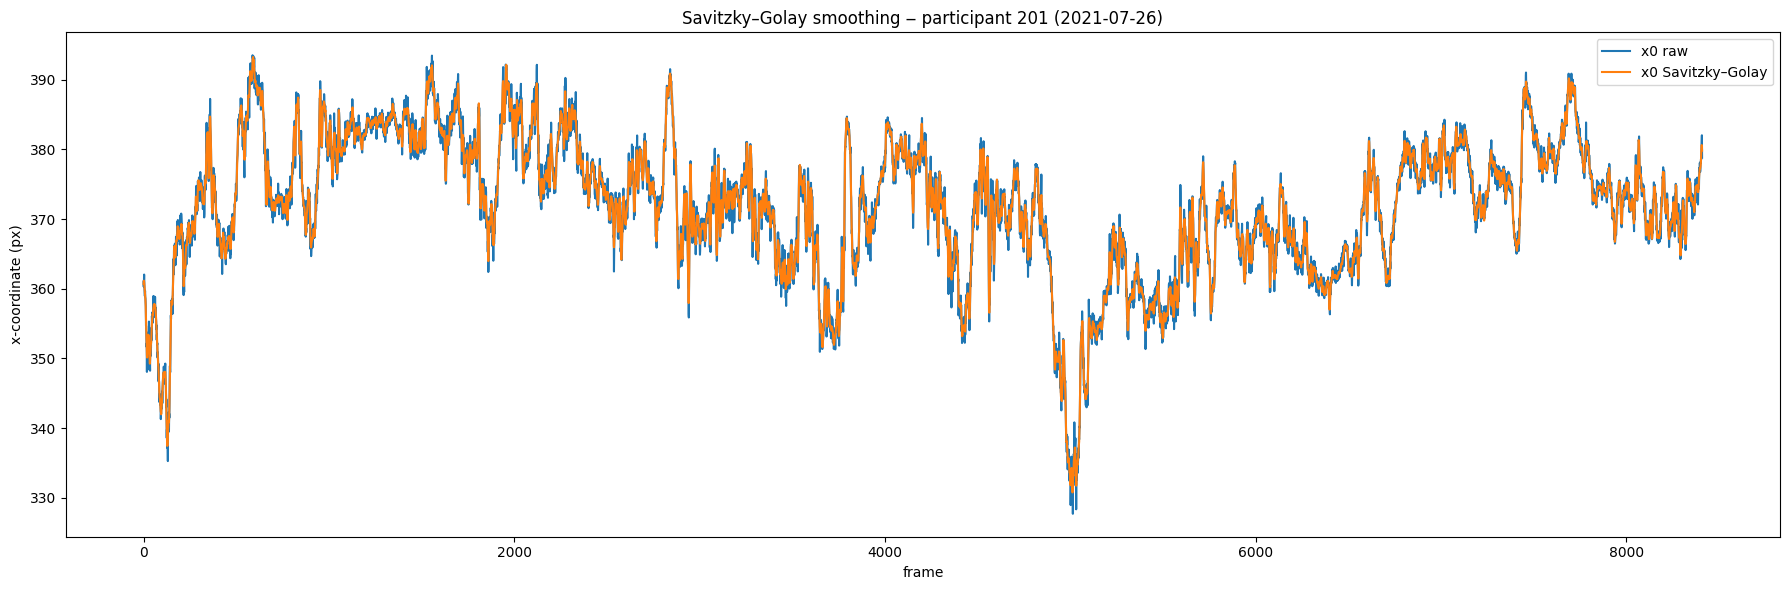

In [ ]:
try:
    keepers
except NameError:
    raise RuntimeError("Please run the parsing & filtering steps first so `keepers` exists.")

# ---------- select first participant/date/camera ----------
first = keepers.iloc[0]
pid, date, cam = first["participant_id"], first["date"], first["camera"]

traj = (keepers[(keepers["participant_id"] == pid) &
                (keepers["date"] == date) &
                (keepers["camera"] == cam)]
        .sort_values("frame_id")
        .reset_index(drop=True))

x_raw = traj["x0"].to_numpy()
y_raw = traj["y0"].to_numpy()

# ---------- Savitzky–Golay smoothing ----------
window = 11          # must be odd; tweak ≥ polynomial order*2 + 1
poly   = 3

x_smooth = savgol_filter(x_raw, window, poly)
y_smooth = savgol_filter(y_raw, window, poly)

# ---------- jerk via analytical 3rd derivative ----------
jerk_x = savgol_filter(x_raw, window, poly, deriv=3, delta=dt)
jerk_y = savgol_filter(y_raw, window, poly, deriv=3, delta=dt)
msj_smooth = np.mean(jerk_x**2 + jerk_y**2)

# ---------- jerk of raw (finite‑difference baseline) ----------
jerk_x_raw = np.diff(x_raw, n=3) / dt**3
jerk_y_raw = np.diff(y_raw, n=3) / dt**3
msj_raw = np.mean(jerk_x_raw**2 + jerk_y_raw**2)

# ---------- outputs ----------
print(f"Participant {pid}, date {date.date()}, camera {cam}")
print(f"Frames analysed: {len(traj)}")
print(f"Mean‑squared jerk (raw)              : {msj_raw:10.2e}")
print(f"Mean‑squared jerk (Savitzky–Golay)   : {msj_smooth:10.2e}")

# ---------- plot ----------
plt.figure(figsize=(18, 6))
plt.plot(traj["frame_id"], x_raw, label="x0 raw")
plt.plot(traj["frame_id"], x_smooth, label="x0 Savitzky–Golay")
plt.xlabel("frame")
plt.ylabel("x‑coordinate (px)")
plt.title(f"Savitzky–Golay smoothing ‒ participant {pid} ({date.date()})")
plt.legend()
plt.tight_layout()


Butterworth / Chebyshev with zero-phase - Classic low-pass; choose a cut-off (e.g. 5 Hz for infant limb motion sampled at 30 fps)

Participant 201, date 2021-07-26, camera 3
Frames analysed: 8410
Mean‑squared jerk (raw)          :   1.86e+10
Mean‑squared jerk (Butterworth)  :   9.22e+07
Mean‑squared jerk (Chebyshev)    :   2.72e+08


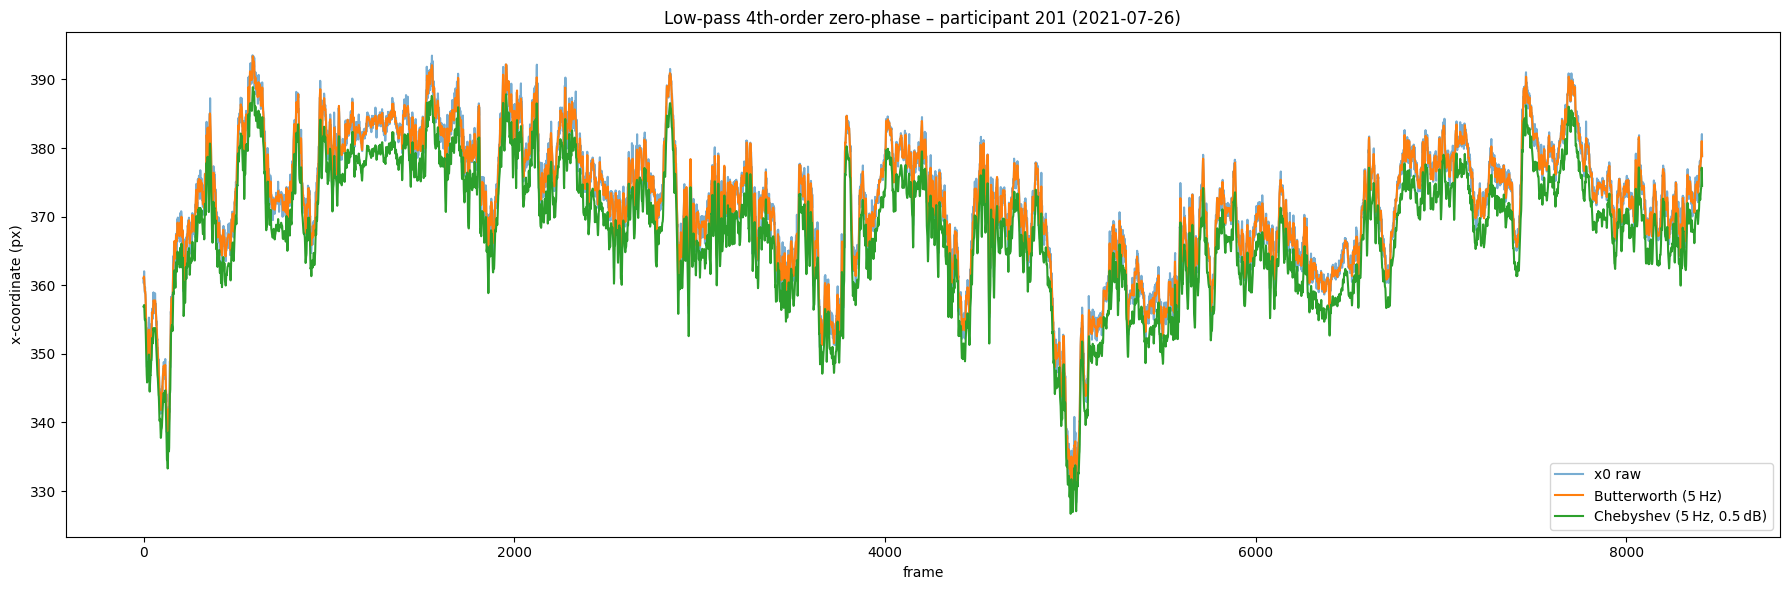

In [ ]:
try:
    keepers
except NameError:
    raise RuntimeError("Run the parsing / smoothing steps first so `keepers` exists.")

# ---------- pick first participant/date/camera ----------
first = keepers.iloc[0]
pid, date, cam = first["participant_id"], first["date"], first["camera"]

traj = (keepers[(keepers["participant_id"] == pid) &
                (keepers["date"] == date) &
                (keepers["camera"] == cam)]
        .sort_values("frame_id")
        .reset_index(drop=True))

x_raw = traj["x0"].to_numpy()
y_raw = traj["y0"].to_numpy()

# ---------- Butterworth zero‑phase low‑pass ---------------------------
fc      = 5.0         # cut‑off frequency [Hz]  (≈ infant limb bandwidth)
order   = 4
wn      = fc / (0.5 * FPS)        # normalised cut‑off
b, a    = butter(order, wn, btype="low", analog=False)
x_bt    = filtfilt(b, a, x_raw)
y_bt    = filtfilt(b, a, y_raw)

# ---------- Chebyshev (optional – comment out if not needed) ----------
rp      = 0.05         # ripple [dB]
b2, a2  = cheby1(order, rp, wn, btype="low")
x_ch    = filtfilt(b2, a2, x_raw)
y_ch    = filtfilt(b2, a2, y_raw)

# ---------- jerk metrics ----------------------------------------------

msj_raw = msj(x_raw, y_raw)
msj_bt  = msj(x_bt,  y_bt)
msj_ch  = msj(x_ch,  y_ch)

print(f"Participant {pid}, date {date.date()}, camera {cam}")
print(f"Frames analysed: {len(traj)}")
print(f"Mean‑squared jerk (raw)          : {msj_raw:10.2e}")
print(f"Mean‑squared jerk (Butterworth)  : {msj_bt:10.2e}")
print(f"Mean‑squared jerk (Chebyshev)    : {msj_ch:10.2e}")

# ---------- plot ------------------------------------------------------
plt.figure(figsize=(18, 6))
plt.plot(traj["frame_id"], x_raw, label="x0 raw", alpha=0.6)
plt.plot(traj["frame_id"], x_bt,  label="Butterworth (5 Hz)")
plt.plot(traj["frame_id"], x_ch,  label="Chebyshev (5 Hz, 0.5 dB)")
plt.xlabel("frame")
plt.ylabel("x‑coordinate (px)")
plt.title(f"Low‑pass 4th‑order zero‑phase – participant {pid} ({date.date()})")
plt.legend()
plt.tight_layout()

Cubic smoothing spline, P-spline, B-spline with GCV - Fits a global spline that trades off fit error vs. integrated squared curvature (≈ a discrete minimum-jerk objective).

Cubic smoothing spline (automatic GCV) – participant 201, 2021-07-26, cam 3
Frames analysed: 8410
Mean‑squared jerk (raw)         :   1.86e+10
Mean‑squared jerk (spline GCV)  :   5.91e-02


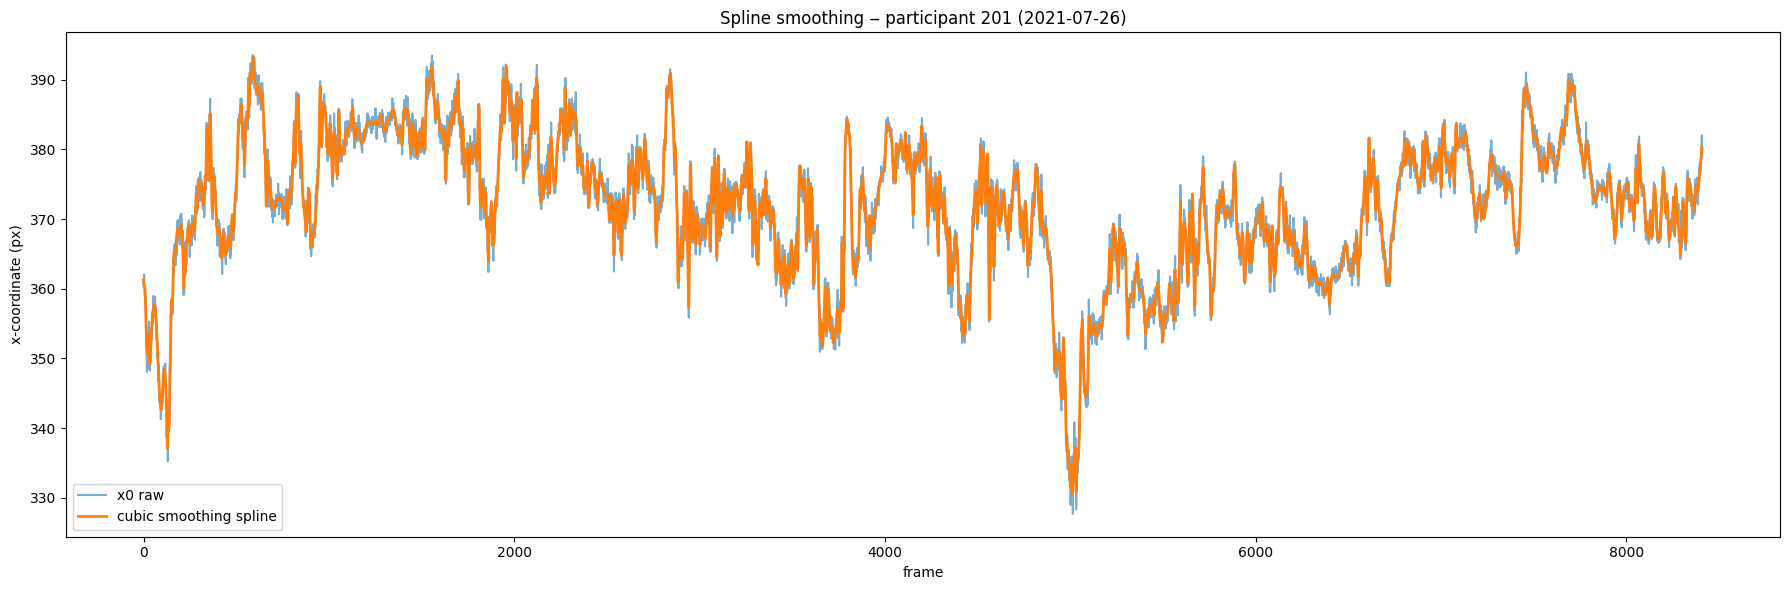

In [ ]:
try:
    keepers
except NameError:
    raise RuntimeError("`keepers` DataFrame not found – run the parsing/filtering cells first.")

# ---------- choose first participant / date / camera ----------
first = keepers.iloc[0]
pid, date, cam = int(first["participant_id"]), first["date"], int(first["camera"])

traj = (keepers[(keepers["participant_id"] == pid) &
                (keepers["date"] == date) &
                (keepers["camera"] == cam)]
        .sort_values("frame_id")
        .reset_index(drop=True))

frames = traj["frame_id"].to_numpy(dtype=float)
x_raw  = traj["x0"].to_numpy()
y_raw  = traj["y0"].to_numpy()

# ---------- cubic smoothing spline with GCV (scipy auto‑s) -----------
# UnivariateSpline with s=None chooses the smoothing factor by a
# cross‑validation‑like criterion (roughly GCV).
spl_x = UnivariateSpline(frames, x_raw, s=None, k=3)
spl_y = UnivariateSpline(frames, y_raw, s=None, k=3)

x_smooth = spl_x(frames)
y_smooth = spl_y(frames)

# ---------- analytic jerk (3rd derivative of spline) -----------------
jerk_x = spl_x.derivative(n=3)(frames)          # already per‑frame
jerk_y = spl_y.derivative(n=3)(frames)
msj_spline = np.mean(jerk_x**2 + jerk_y**2)

# ---------- raw jerk for baseline -----------------------------------
jerk_x_raw = np.diff(x_raw, n=3) / dt**3
jerk_y_raw = np.diff(y_raw, n=3) / dt**3
msj_raw    = np.mean(jerk_x_raw**2 + jerk_y_raw**2)

# ---------- report ---------------------------------------------------
print(f"Cubic smoothing spline (automatic GCV) – participant {pid}, {date.date()}, cam {cam}")
print(f"Frames analysed: {len(frames)}")
print(f"Mean‑squared jerk (raw)         : {msj_raw:10.2e}")
print(f"Mean‑squared jerk (spline GCV)  : {msj_spline:10.2e}")

# ---------- plot -----------------------------------------------------
plt.figure(figsize=(18, 6))
plt.plot(frames, x_raw, label="x0 raw", alpha=0.6)
plt.plot(frames, x_smooth, label="cubic smoothing spline", linewidth=2)
plt.xlabel("frame")
plt.ylabel("x‑coordinate (px)")
plt.title(f"Spline smoothing ‒ participant {pid} ({date.date()})")
plt.legend()
plt.tight_layout()

Kalman Filter - Treat pose as latent state; learn process & measurement noise, then run a Rauch–Tung–Striebel (RTS) smoother (forward + backward pass).

In [ ]:
from filters import kalman_smooth_xy

RTS smoother (constant acceleration) – participant 201, 2021-07-26, cam 3
Frames analysed: 8410
Mean‑squared jerk (raw)      :   1.86e+10
Mean‑squared jerk (RTS Kalman):   1.26e+04


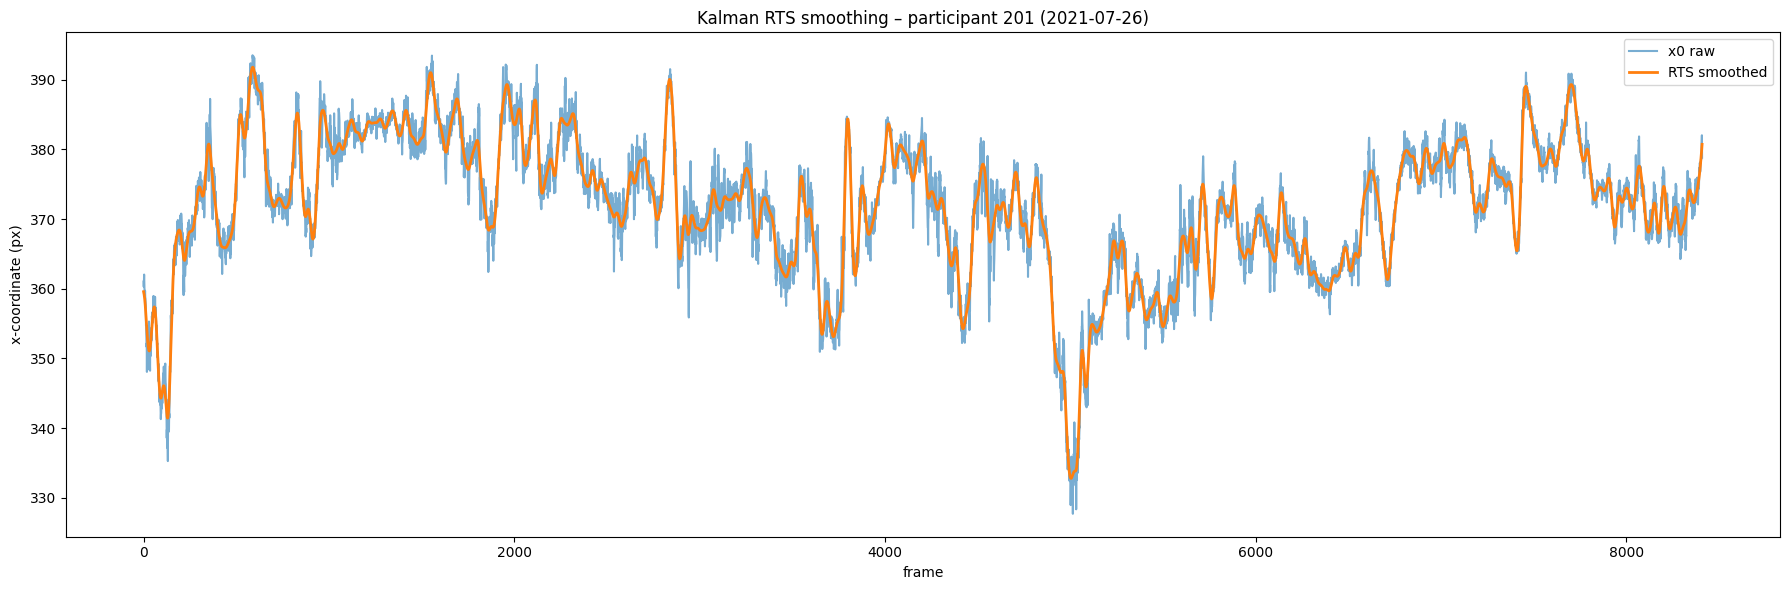

In [ ]:
try:
    keepers
except NameError:
    raise RuntimeError("Run the parsing/filtering notebook cells first to create `keepers`.")

# ---------- select first participant / date / camera ----------
first = keepers.iloc[0]
pid, date, cam = int(first["participant_id"]), first["date"], int(first["camera"])

traj = (keepers[(keepers["participant_id"] == pid) &
                (keepers["date"] == date) &
                (keepers["camera"] == cam)]
        .sort_values("frame_id")
        .reset_index(drop=True))

frames = traj["frame_id"].to_numpy(dtype=float)
x_obs  = traj["x0"].to_numpy()
y_obs  = traj["y0"].to_numpy()
n      = len(frames)

# ---------- build constant‑acceleration state‑space model ----------
# state: [x, y, vx, vy, ax, ay]   (6‑D)
A = np.eye(6)
A[0,2] = dt
A[1,3] = dt
A[0,4] = 0.5*dt**2
A[1,5] = 0.5*dt**2
A[2,4] = dt
A[3,5] = dt

H = np.zeros((2,6))
H[0,0] = 1
H[1,1] = 1

# process noise Q: assume acceleration is a random walk (jerk variance)
q_jerk   = 125        # tune ↓ if too smooth, ↑ if too rough (pixel ² / s⁶)
Q = np.zeros((6,6))
Q[4,4] = q_jerk
Q[5,5] = q_jerk

# measurement noise R
tau_px  = 4.0         # 1‑σ ≈ 4 px (based on key‑point scores)
R = np.diag([tau_px**2, tau_px**2])

# initial state
x0 = np.array([x_obs[0], y_obs[0], 0, 0, 0, 0], dtype=float)
P0 = np.diag([tau_px**2, tau_px**2, 10.0, 10.0, 100.0, 100.0])

# ---------- Kalman filter & RTS smoother ----------
xs = np.zeros((n,6))
Ps = np.zeros((n,6,6))

# forward pass
x_pred, P_pred = x0, P0
for t in range(n):
    # update
    z = np.array([x_obs[t], y_obs[t]])
    S   = H @ P_pred @ H.T + R
    K   = P_pred @ H.T @ np.linalg.inv(S)
    y_t = z - H @ x_pred
    x_upd = x_pred + K @ y_t
    P_upd = (np.eye(6) - K @ H) @ P_pred

    xs[t] = x_upd
    Ps[t] = P_upd

    # predict next
    x_pred = A @ x_upd
    P_pred = A @ P_upd @ A.T + Q

# RTS backward smoother
for t in range(n-2, -1, -1):
    P_upd = Ps[t]
    P_pred_next = A @ P_upd @ A.T + Q
    C = P_upd @ A.T @ np.linalg.inv(P_pred_next)
    xs[t] = xs[t] + C @ (xs[t+1] - A @ xs[t])
    Ps[t] = P_upd + C @ (Ps[t+1] - P_pred_next) @ C.T

x_kal = xs[:,0]
y_kal = xs[:,1]
acc_x = xs[:,4]
acc_y = xs[:,5]

# ---------- jerk & metrics ----------
jerk_x = np.diff(acc_x) / dt
jerk_y = np.diff(acc_y) / dt
msj_kal = np.mean(jerk_x**2 + jerk_y**2)

jerk_x_raw = np.diff(x_obs, n=3) / dt**3
jerk_y_raw = np.diff(y_obs, n=3) / dt**3
msj_raw = np.mean(jerk_x_raw**2 + jerk_y_raw**2)

print(f"RTS smoother (constant acceleration) – participant {pid}, {date.date()}, cam {cam}")
print(f"Frames analysed: {n}")
print(f"Mean‑squared jerk (raw)      : {msj_raw:10.2e}")
print(f"Mean‑squared jerk (RTS Kalman): {msj_kal:10.2e}")

# ---------- plot ------------------------------------------------------
plt.figure(figsize=(18, 6))
plt.plot(frames, x_obs, label="x0 raw", alpha=0.6)
plt.plot(frames, x_kal, label="RTS smoothed", linewidth=2)
plt.xlabel("frame")
plt.ylabel("x‑coordinate (px)")
plt.title(f"Kalman RTS smoothing – participant {pid} ({date.date()})")
plt.legend()
plt.tight_layout()

# Splitting into Body Parts

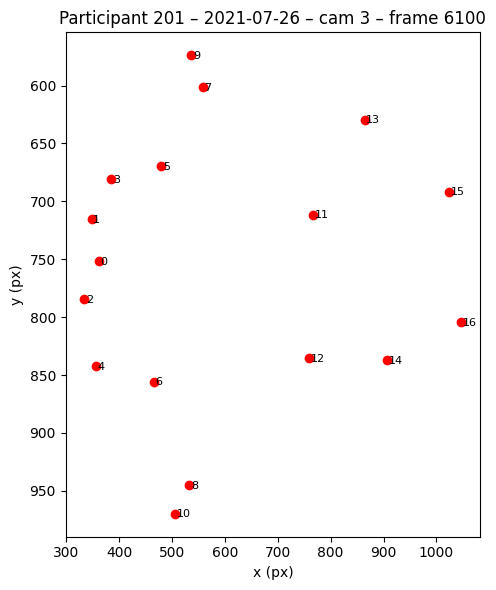

In [16]:
try:
    keepers
except NameError:
    raise RuntimeError("Run the earlier parsing/filter cells first so `keepers` exists.")

# --------- select a frame to visualise --------
# Feel free to change these three identifiers ↓
pid   = int(keepers.iloc[0]["participant_id"])
date  = keepers.iloc[0]["date"]
cam   = int(keepers.iloc[0]["camera"])
fid   = int(keepers.iloc[6100]["frame_id"])    # first frame

row = keepers[(keepers["participant_id"] == pid) &
              (keepers["date"] == date) &
              (keepers["camera"] == cam) &
              (keepers["frame_id"] == fid)].iloc[0]

# collect x,y
xs = [row[f"x{i}"] for i in range(17)]
ys = [row[f"y{i}"] for i in range(17)]

# --------- simple scatter plot ---------------
plt.figure(figsize=(5,6))
plt.scatter(xs, ys, c="red")
for i, (x, y) in enumerate(zip(xs, ys)):
    plt.text(x+3, y+3, str(i), fontsize=8)

plt.gca().invert_yaxis()   # image coords: origin top‑left
plt.title(f"Participant {pid} – {date.date()} – cam {cam} – frame {fid}")
plt.xlabel("x (px)")
plt.ylabel("y (px)")
plt.tight_layout()

In [ ]:
parts_idx = {
    "nose"       : [0],
    "left_eye"   : [1],
    "right_eye"  : [2],
    "left_ear"   : [3],
    "right_ear"  : [4],
    "left_arm"   : [5, 7, 9],        # shoulder, elbow, hand
    "right_arm"  : [6, 8, 10],
    "left_leg"   : [11, 13, 15],
    "right_leg"  : [12, 14, 16],
}

# aggregate maps (e.g. eyes = both eyes, arms = L+R, legs = L+R)
groups = {
    "eyes" : parts_idx["left_eye"] + parts_idx["right_eye"],
    "ears" : parts_idx["left_ear"] + parts_idx["right_ear"],
    "left_arm"  : parts_idx["left_arm"],
    "right_arm" : parts_idx["right_arm"],
    "left_leg"  : parts_idx["left_leg"],
    "right_leg" : parts_idx["right_leg"],
    "nose" : parts_idx["nose"],
}

# --------------------------------------------------------------------
# 2. Compute confidence per body‑part (frame‑wise mean of its key‑points)
assert set(SCORE_COLS).issubset(keepers.columns), "Missing score columns"

# ---- per-frame confidence for all 17 single key‑points -------------
keepers_single = keepers.copy()  # already has score0 … score16

# ---- per-frame aggregated confidence by groups ---------------------
for part, idxs in groups.items():
    keepers_single[f"conf_{part}"] = keepers_single.apply(part_confidence, axis=1, idxs=idxs)

# Display sample for verification
display_cols = ["date", "camera", "participant_id", "frame_id"] + [f"conf_{p}" for p in groups]
print(keepers_single[display_cols].head())

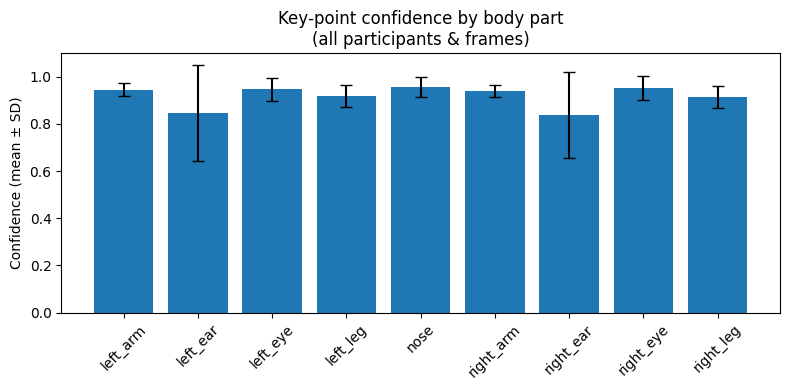

In [ ]:
parts_idx = {
    "nose": [0],
    "left_eye": [1],
    "right_eye": [2],
    "left_ear": [3],
    "right_ear": [4],
    "left_arm": [5, 7, 9],
    "right_arm": [6, 8, 10],
    "left_leg": [11, 13, 15],
    "right_leg": [12, 14, 16],
}

# ---- compute mean & std across all rows for each body part ---------
stats = []
for part, idxs in parts_idx.items():
    cols = [f"score{i}" for i in idxs]
    vals = keepers[cols].mean(axis=1)   # per‑row mean across that part
    stats.append({"body_part": part,
                  "mean_conf": vals.mean(),
                  "std_conf":  vals.std()})

conf_df = pd.DataFrame(stats).sort_values("body_part")

# ---- bar plot with error bars --------------------------------------
plt.figure(figsize=(8,4))
plt.bar(conf_df["body_part"], conf_df["mean_conf"], yerr=conf_df["std_conf"], capsize=4)
plt.ylabel("Confidence (mean ± SD)")
plt.title("Key‑point confidence by body part\n(all participants & frames)")
plt.xticks(rotation=45)
plt.tight_layout()

# Filter Comparison

In [ ]:
window, poly = 11, 3
butter_ba = butter(4, 5.0/(0.5*FPS), btype="low")
cheby_ba  = cheby1(4, 0.05, 5.0/(0.5*FPS), btype="low")



filter_fns={
    "raw":    lambda x,y,fr: (x,y),
    "minjerk":lambda x,y,fr: (min_jerk_1d(x), min_jerk_1d(y)),
    "gauss"   : lambda x, y, fr: gauss_smooth(x, y),  
    "savgol": lambda x,y,fr: (savgol_filter(x,window,poly), savgol_filter(y,window,poly)),
    "butter": lambda x,y,fr: (filtfilt(*butter_ba,x), filtfilt(*butter_ba,y)),
    "cheby":  lambda x,y,fr: (filtfilt(*cheby_ba,x),  filtfilt(*cheby_ba,y)),
    "spline": lambda x,y,fr: (UnivariateSpline(fr,x,s=None,k=3)(fr),
                              UnivariateSpline(fr,y,s=None,k=3)(fr)),
    "kalman": lambda x,y,fr: kalman_smooth_xy(x,y)
}
filters = list(filter_fns.keys())

# key‑point names
kp_names = {0:"nose",1:"left_eye",2:"right_eye",3:"left_ear",4:"right_ear",
            5:"left_shoulder",6:"right_shoulder",7:"left_elbow",8:"right_elbow",
            9:"left_hand",10:"right_hand",11:"left_hip",12:"right_hip",
            13:"left_knee",14:"right_knee",15:"left_foot",16:"right_foot"}

# body part mapping
parts_idx = {
    "nose":[0],
    "eyes":[1,2],
    "ears":[3,4],
    "left_arm":[5,7,9],
    "right_arm":[6,8,10],
    "left_leg":[11,13,15],
    "right_leg":[12,14,16]
}

In [185]:
rmse_vals = {(f,k):[] for f in filters for k in range(17)}
kappa_vals= {f:[] for f in filters}

for (pid,date,cam), session in keepers.groupby(["participant_id","date","camera"]):
    session = session.sort_values("frame_id")
    frames = session["frame_id"].to_numpy(dtype=float)
    # loop filters
    for f in filters:
        # prepare shoulders storage for κ
        xs5=ys5=xs6=ys6=None
        for k in range(17):
            xr = session[f"x{k}"].to_numpy()
            yr = session[f"y{k}"].to_numpy()
            xs, ys = filter_fns[f](xr,yr,frames)
            # RMSE
            rmse_vals[(f,k)].append(np.sqrt(np.mean((xs-xr)**2 + (ys-yr)**2)))
            if k==5: xs5,ys5 = xs,ys
            if k==6: xs6,ys6 = xs,ys
        # κ for this session
        dist = np.sqrt((xs5-xs6)**2 + (ys5-ys6)**2)
        kappa_vals[f].append(np.std(dist)/np.mean(dist))

# Compute mean & std
rmse_mean = {(f,k): np.mean(v) for (f,k),v in rmse_vals.items()}
rmse_std  = {(f,k): np.std(v)  for (f,k),v in rmse_vals.items()}
kappa_mean= {f: np.mean(v) for f,v in kappa_vals.items()}
kappa_std = {f: np.std(v)  for f,v in kappa_vals.items()}

# confidence
kp_conf_vals = {k: keepers[f"score{k}"].values for k in range(17)}
kp_conf_mean = {kp_names[k]: np.mean(v) for k,v in kp_conf_vals.items()}
kp_conf_std  = {kp_names[k]: np.std(v)  for k,v in kp_conf_vals.items()}

part_conf_vals = {p: keepers[[f"score{i}" for i in idx]].mean(axis=1).values
                  for p,idx in parts_idx.items()}
part_conf_mean = {p: np.mean(v) for p,v in part_conf_vals.items()}
part_conf_std  = {p: np.std(v)  for p,v in part_conf_vals.items()}

C:\Users\ioana\AppData\Local\Temp\ipykernel_25896\1082324391.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(part_conf_vals.keys(), rotation=45, ha='right')
C:\Users\ioana\AppData\Local\Temp\ipykernel_25896\1082324391.py:63: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\ioana\anaconda3\envs\robo_summer_2025\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\Users\ioana\anaconda3\envs\robo_summer_2025\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


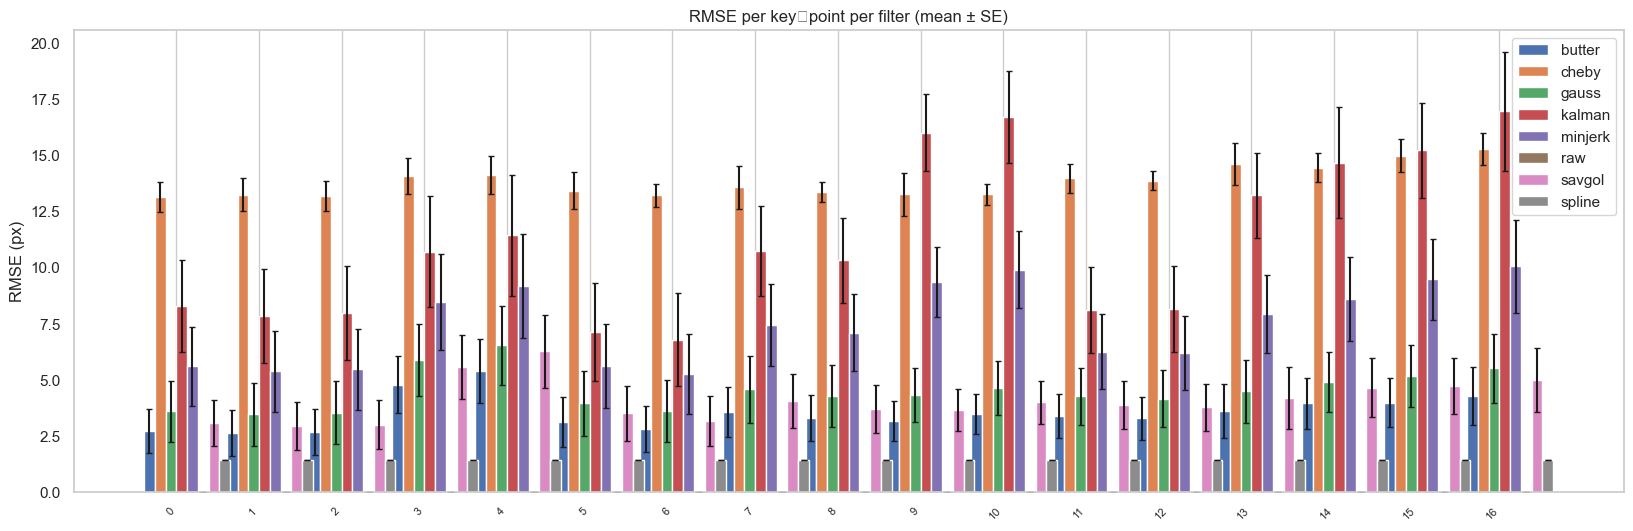

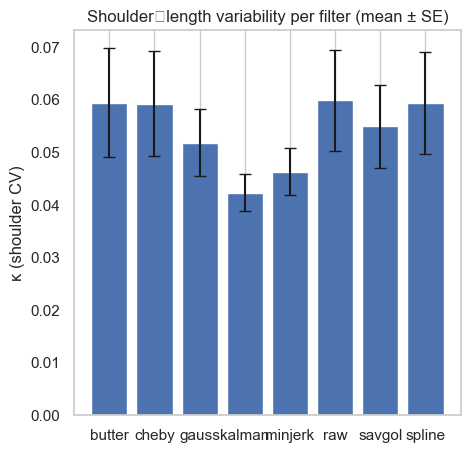

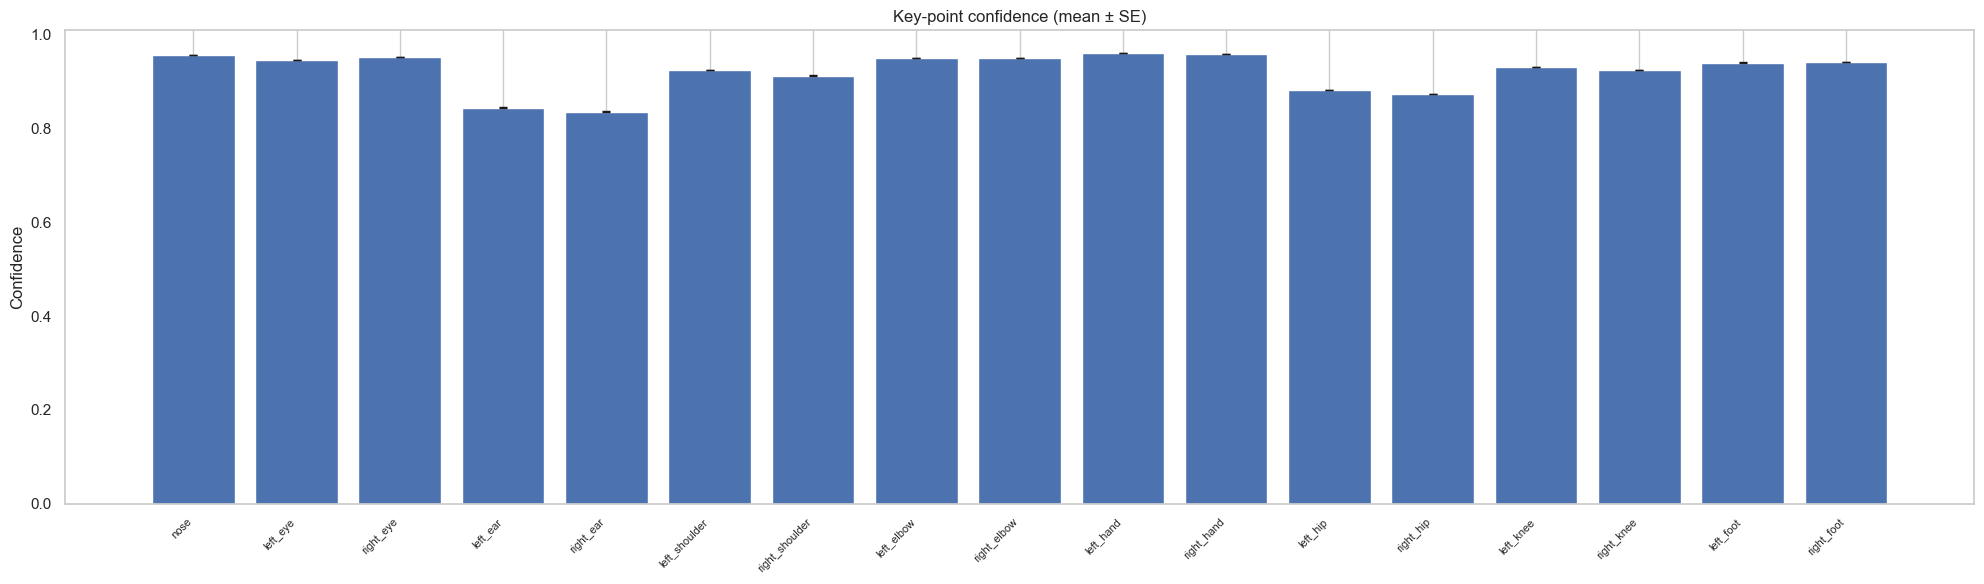

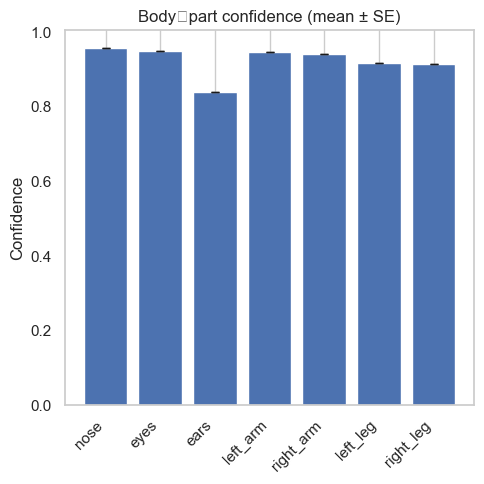

In [ ]:
# 1. RMSE (mean ± SE) per key‑point & filter
filters = sorted({f for (f,_) in rmse_vals})
num_kp  = 17
x = np.arange(num_kp)
width = 0.13

fig1, ax1 = plt.subplots(figsize=(20,6))
ax1.grid(axis='y')
for i,f in enumerate(filters):
    means = [np.mean(rmse_vals[(f,k)]) for k in range(17)]
    ses   = [se(rmse_vals[(f,k)])      for k in range(17)]
    ax1.bar(x + (i-2.5)*width, means, width, yerr=ses, capsize=2, label=f)

ax1.set_xticks(x)
ax1.set_xticklabels([k for k in kp_conf_vals.keys()], rotation=45, ha='right', fontsize=8)
ax1.set_ylabel("RMSE (px)")
ax1.set_title("RMSE per key‑point per filter (mean ± SE)")
ax1.legend()

# 2. k (shoulder CV) per filter (mean ± SE)
fig2, ax2 = plt.subplots(figsize=(5,5))
ax2.grid(axis='y')
ax2.bar(filters,
        [np.mean(kappa_vals[f]) for f in filters],
        yerr=[se(kappa_vals[f]) for f in filters],
        capsize=4)
ax2.set_ylabel("κ (shoulder CV)")
ax2.set_title("Shoulder‑length variability per filter (mean ± SE)")

# 3. Key‑point confidence (mean ± SE)
kp_labels = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_hand", "right_hand", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_foot", "right_foot"
]
kp_conf_vals_inv = {kp_names[k]: kp_conf_vals[k] for k in range(17)}
kp_means = [np.mean(kp_conf_vals_inv[l]) for l in kp_labels]
kp_ses   = [se(kp_conf_vals_inv[l])     for l in kp_labels]
fig3, ax3 = plt.subplots(figsize=(24,6))
ax3.grid(axis='y')
ax3.bar(x, kp_means, yerr=kp_ses, capsize=3)
ax3.set_xticks(x)
ax3.set_xticklabels(kp_labels, rotation=45, ha='right', fontsize=8)
ax3.set_ylabel("Confidence")
ax3.set_title("Key-point confidence (mean ± SE)")

plt.tight_layout()

# 4. Body‑part confidence (mean ± SE)
fig4, ax4 = plt.subplots(figsize=(5,5))
bp_means = [np.mean(v) for v in part_conf_vals.values()]
bp_ses   = [se(v) for v in part_conf_vals.values()]
ax4.grid(axis='y')
ax4.bar(part_conf_vals.keys(), bp_means, yerr=bp_ses, capsize=3)
ax4.set_xticklabels(part_conf_vals.keys(), rotation=45, ha='right')
ax4.set_ylabel("Confidence")
ax4.set_title("Body‑part confidence (mean ± SE)")

plt.tight_layout()

In [187]:
rmse_frame = {f: [] for f in filters}

for (pid,date,cam), session in keepers.groupby(["participant_id","date","camera"]):
    session = session.sort_values("frame_id")
    frames  = session["frame_id"].to_numpy(dtype=float)
    # raw coords matrix: shape (n_frames, 17, 2)
    raw = np.stack([session[[f"x{i}" for i in range(17)]].values,
                    session[[f"y{i}" for i in range(17)]].values], axis=-1)
    n_frames = raw.shape[0]

    for f in filters:
        se = np.zeros(n_frames)
        for k in range(17):
            xs,ys = filter_fns[f](raw[:,k,0], raw[:,k,1], frames)
            se += (xs - raw[:,k,0])**2 + (ys - raw[:,k,1])**2   # accumulate squared error
        rmse_frame[f].extend(np.sqrt(se/17))   # per-frame RMSE (averaged over 17 joints)


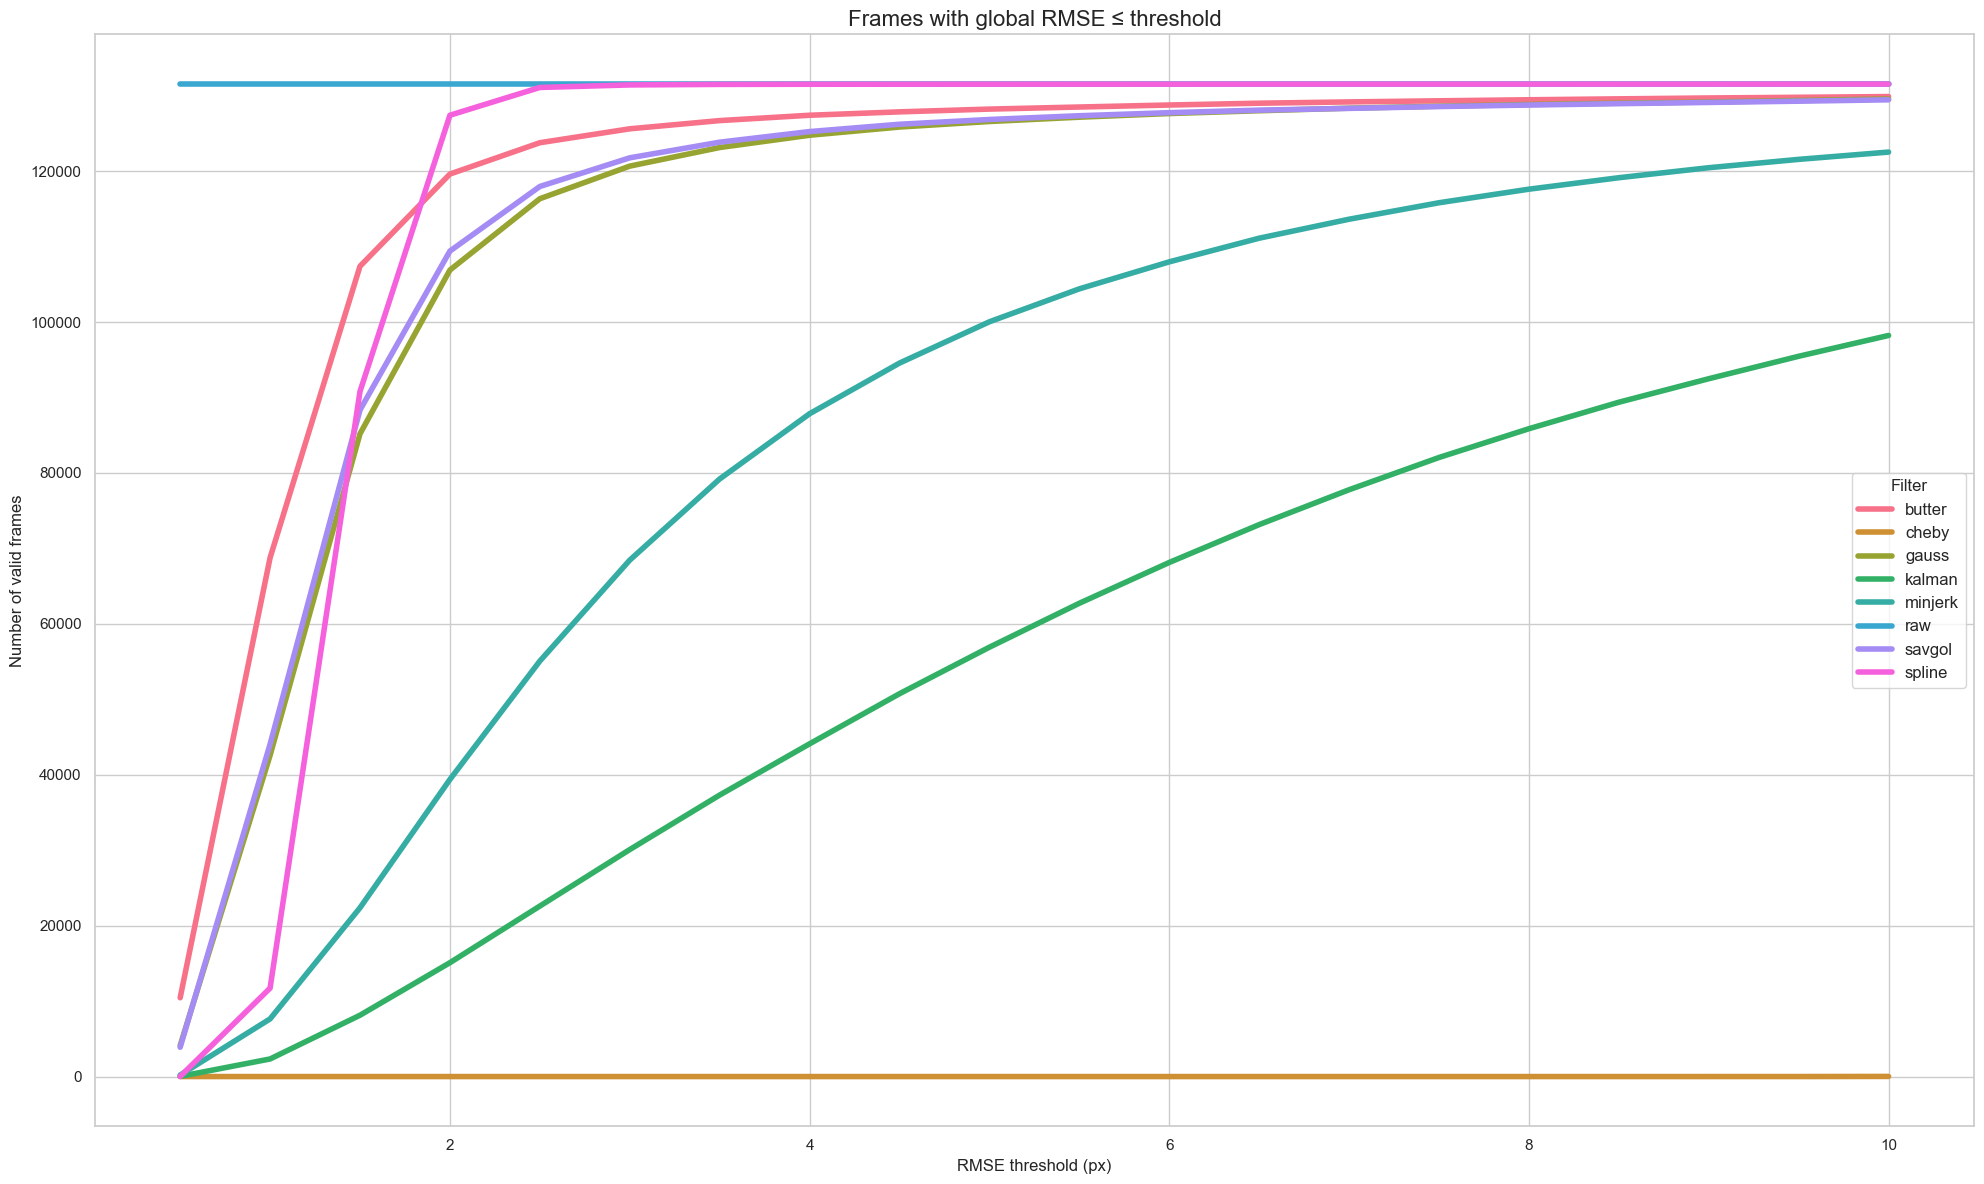

In [188]:
thresholds = np.linspace(0.5, 10, 20)   # RMSE thresholds (px) – adjust
rows=[]
for f in filters:
    rmse_vec = np.array(rmse_frame[f])
    for thr in thresholds:
        mask = rmse_vec <= thr
        rows.append({
            "algo":f,
            "threshold":thr,
            "num_frames":mask.sum(),
            "se": mask.std()/sqrt(len(mask))
        })

df_plot = pd.DataFrame(rows)

# ---------- plot ----------------------------------------------------
palette = sns.color_palette("husl", n_colors=len(filters))
plt.figure(figsize=(20,12))
for i,f in enumerate(filters):
    sub = df_plot[df_plot["algo"]==f]
    plt.plot(sub["threshold"], sub["num_frames"], label=f,
             linewidth=4, color=palette[i])
    plt.fill_between(sub["threshold"],
                     sub["num_frames"]-sub["se"],
                     sub["num_frames"]+sub["se"],
                     alpha=0.25, color=palette[i])


plt.title("Frames with global RMSE ≤ threshold", fontsize=16)
plt.xlabel("RMSE threshold (px)")
plt.ylabel("Number of valid frames")
plt.legend(title="Filter", fontsize=12)
plt.tight_layout()
plt.savefig("frames_with_RMSE_below_threshold.png")
plt.show()

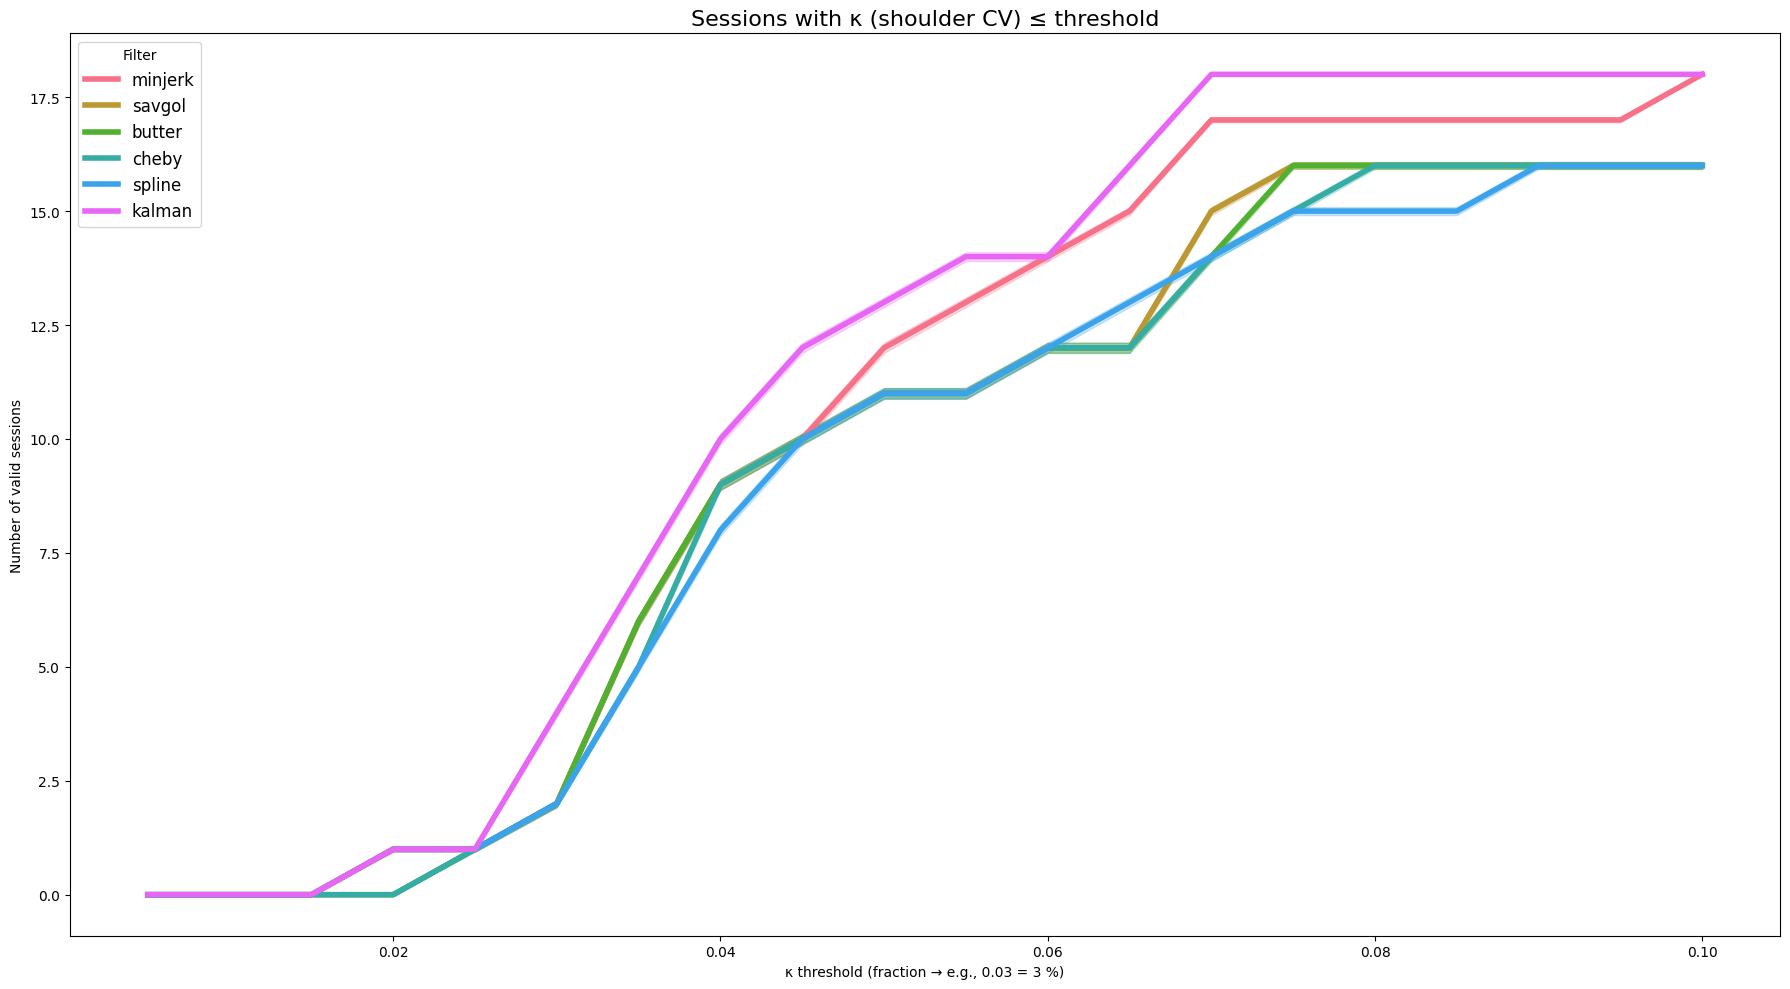

In [ ]:
k_thresholds = np.linspace(0.005, 0.10, 20)

rows = []
for f in kappa_vals.keys():
    kappas = np.array(kappa_vals[f])          # one κ per session
    for thr in k_thresholds:
        mask = kappas <= thr
        rows.append({
            "algo": f,
            "threshold": thr,
            "num_sessions": mask.sum(),
            "se": mask.std() / sqrt(len(mask))   # SE over (0/1) indicator
        })

df_k = pd.DataFrame(rows)

# ── plot ─────────────────────────────────────────────────────────────
palette = sns.color_palette("husl", n_colors=len(kappa_vals))
plt.figure(figsize=(18,10))

for i, f in enumerate(kappa_vals.keys()):
    sub = df_k[df_k["algo"] == f]
    plt.plot(sub["threshold"], sub["num_sessions"],
             label=f, linewidth=4, color=palette[i])
    plt.fill_between(sub["threshold"],
                     sub["num_sessions"] - sub["se"],
                     sub["num_sessions"] + sub["se"],
                     alpha=0.25, color=palette[i])

plt.title("Sessions with κ (shoulder CV) ≤ threshold", fontsize=16)
plt.xlabel("κ threshold (fraction → e.g., 0.03 = 3 %)")
plt.ylabel("Number of valid sessions")
plt.legend(title="Filter", fontsize=12)
plt.tight_layout()
plt.savefig("sessions_with_kappa_below_threshold.png")
plt.show()

# Feature Computation and Filter Effect Comparison

In [22]:
feature_rows = []

for key, session in keepers_long.groupby(["participant_id", "date", "camera"]):
    # session is guaranteed to have ≥ MIN_FRAMES rows
    feats = {}
    feats.update(features_wrist_block(session))
    feats.update(features_ankle_block(session))
    feats.update(features_knee_block(session))
    feats.update(features_elbow_block(session))

    pid, date, cam = key
    feats.update({"participant": pid,
                  "date": date,
                  "camera": cam,
                  "n_frames": len(session)})

    feature_rows.append(feats)

feature_df = pd.DataFrame(feature_rows)


# Seeing how different filters affect the features we computed

In [ ]:
# ------------------------------------------------
#  Define every smoother in ONE dictionary
#  ------------------------------------------------
from filters import baseline_filter, filter_fns

In [ ]:
# Batch over every long recording & every filter
feature_rows = []

for key, session in keepers_long.groupby(["participant_id","date","camera"]):
    session = session.sort_values("frame_id")

    for f_name, f_fn in filter_fns.items():          # ← loop filters
        feature_rows.append(all_features_for_session(session, f_name, f_fn))

feat_long = pd.DataFrame(feature_rows)

# compute the distribution-shift mrtrics
id_cols   = ["participant","date","camera"]      # group keys
value_cols= [c for c in feat_long.columns if c not in id_cols+["filter","n_frames"]]

# baseline values per recording
baseline = (feat_long.query("filter == 'baseline'")
                     .set_index(id_cols)[value_cols])

shift_rows=[]
for f in filter_fns.keys():
    if f == "baseline":              # skip self-comparison
        continue
    sub = (feat_long.query("filter == @f")
                     .set_index(id_cols)[value_cols])
    for feat in value_cols:
        raw  = baseline[feat].values
        test = sub[feat].values
        shift_rows.append({
            "filter": f,
            "feature": feat,
            "d_mean":  np.mean(test) - np.mean(raw),
            "d_median":np.median(test) - np.median(raw),
            "ks":      ks_2samp(raw, test).statistic
        })
shift_df = pd.DataFrame(shift_rows)

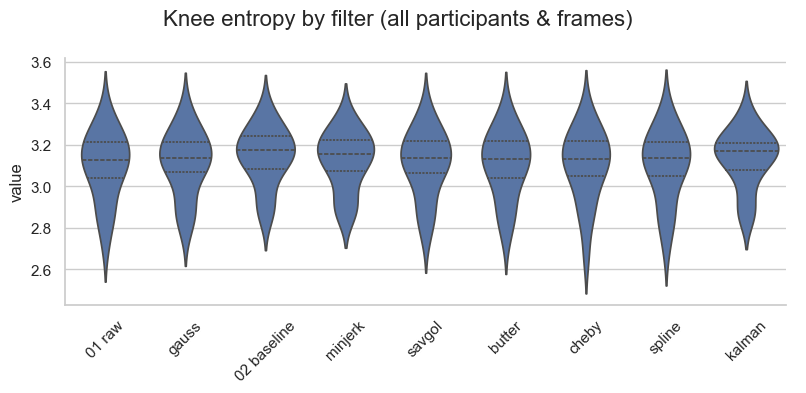

In [205]:
g = sns.catplot(
        data=feat_long.replace({"raw":"01 raw", "baseline":"02 baseline"}),
        x="filter", y="kn_entropy",        # <── pick any feature here
        kind="violin", inner="quartile", height=4, aspect=2)
g.set_titles("{col_name}"); g.set_xlabels(""); g.set_ylabels("value")
# set titple to kn_entropy
g.fig.suptitle("Knee entropy by filter (all participants & frames)", fontsize=16)
g.tight_layout()
plt.xticks(rotation=45); plt.tight_layout()

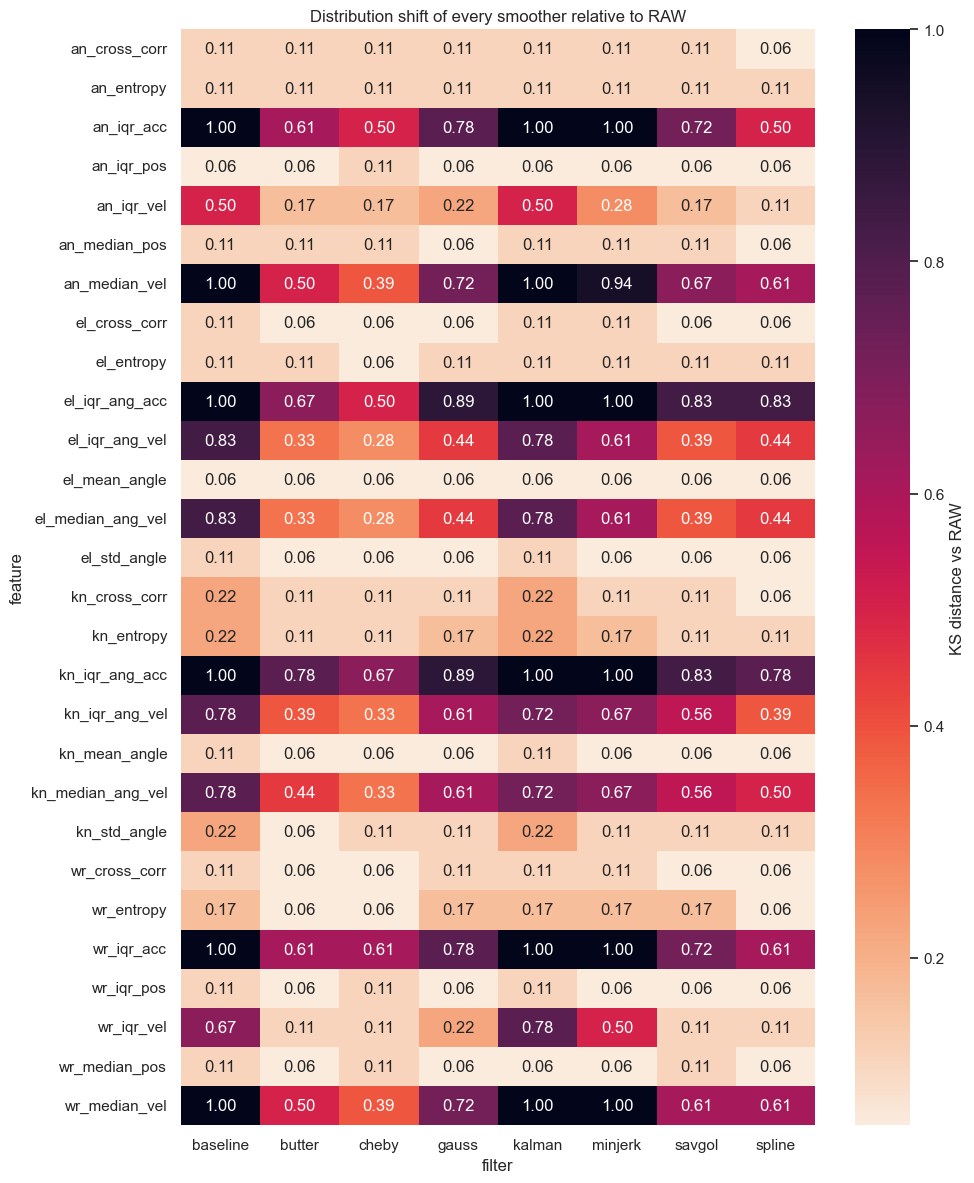

In [ ]:
# -----------------------------------------------
# 1.  C of every filter *vs RAW*
# -----------------------------------------------
# Kolmogorov–Smirnov (KS) “distance” = the largest vertical gap between two cumulative-distribution curves
id_cols    = ["participant", "date", "camera"]
value_cols = [c for c in feat_long.columns
              if c not in id_cols + ["filter", "n_frames"]]

raw_feats = (feat_long                       # ⬅ raw reference
             .query("filter == 'raw'")
             .set_index(id_cols)[value_cols])

rows = []
for f in filter_fns.keys():
    if f == "raw":                      # skip self-comparison
        continue
    test_feats = (feat_long
                  .query("filter == @f")
                  .set_index(id_cols)[value_cols])

    for feat in value_cols:
        ks = ks_2samp(raw_feats[feat].values,
                       test_feats[feat].values).statistic
        rows.append({"feature": feat, "filter": f, "ks": ks})

shift_raw_df = pd.DataFrame(rows)

# -----------------------------------------------
# 2.  Heat-map  (rows = features, cols = filters)
# -----------------------------------------------
pivot = (shift_raw_df
         .pivot(index="feature", columns="filter", values="ks")
         .sort_index())

plt.figure(figsize=(10, 12))
sns.heatmap(pivot,
            cmap="rocket_r",
            annot=True,
            fmt=".2f",
            cbar_kws={"label": "KS distance vs RAW"})
plt.title("Distribution shift of every smoother relative to RAW")
plt.tight_layout()


In [207]:
N_BINS = 64          # for J-S; keep fixed for every feature
EPS    = 1e-12       # to avoid log(0)

id_cols    = ["participant", "date", "camera"]
value_cols = [c for c in feat_long.columns             
              if c not in id_cols + ["filter", "n_frames"]]

raw_feats = (feat_long.query("filter=='raw'")
                       .set_index(id_cols)[value_cols])

rows = []
for f_name in filter_fns.keys():
    if f_name == "raw":
        continue

    test_feats = (feat_long.query("filter == @f_name")
                             .set_index(id_cols)[value_cols])

    for feat in value_cols:
        a = raw_feats[feat].values    # pooled RAW
        b = test_feats[feat].values   # pooled smoothed

        # --- basic stats ---
        mu_a, mu_b   = a.mean(), b.mean()
        sd_a, sd_b   = a.std(ddof=1), b.std(ddof=1)
        sd_pool      = np.sqrt(((len(a)-1)*sd_a**2 + (len(b)-1)*sd_b**2)
                               / (len(a)+len(b)-2))

        # --- histogram for JS ---
        lo, hi = np.min([a.min(), b.min()]), np.max([a.max(), b.max()])
        bins   = np.linspace(lo, hi, N_BINS+1)
        p, _   = np.histogram(a, bins=bins, density=True)
        q, _   = np.histogram(b, bins=bins, density=True)
        p, q   = p+EPS, q+EPS                         # avoid zeros
        p, q   = p/p.sum(), q/q.sum()                 # normalise

        rows.append({
            "filter"   : f_name,
            "feature"  : feat,
            "d_mean"   : abs(mu_b - mu_a),
            "cohen_d"  : abs((mu_b - mu_a) / sd_pool),
            "wasser1"  : wasserstein_distance(a, b),
            "energy"   : energy_distance(a, b),
            "js"       : jensenshannon(p, q)          # already √JS
        })

shift_multi_df = pd.DataFrame(rows)

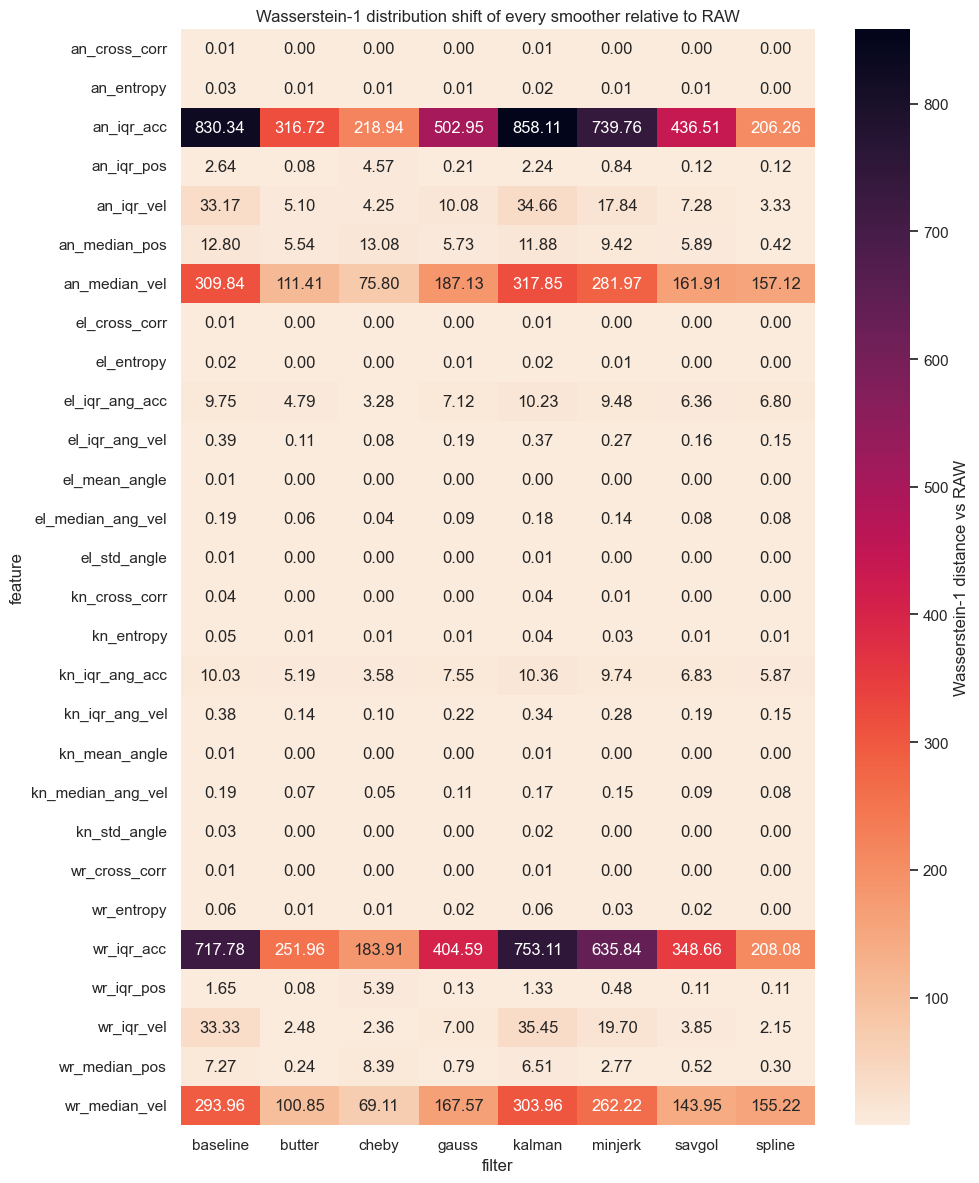

In [208]:
pivot = (shift_multi_df.pivot(index="feature", columns="filter", values="wasser1")
         .sort_index())

plt.figure(figsize=(10, 12))
sns.heatmap(pivot,
            cmap="rocket_r",
            annot=True,
            fmt=".2f",
            cbar_kws={"label": "Wasserstein-1 distance vs RAW"})
plt.title("Wasserstein-1 distribution shift of every smoother relative to RAW")
plt.tight_layout()

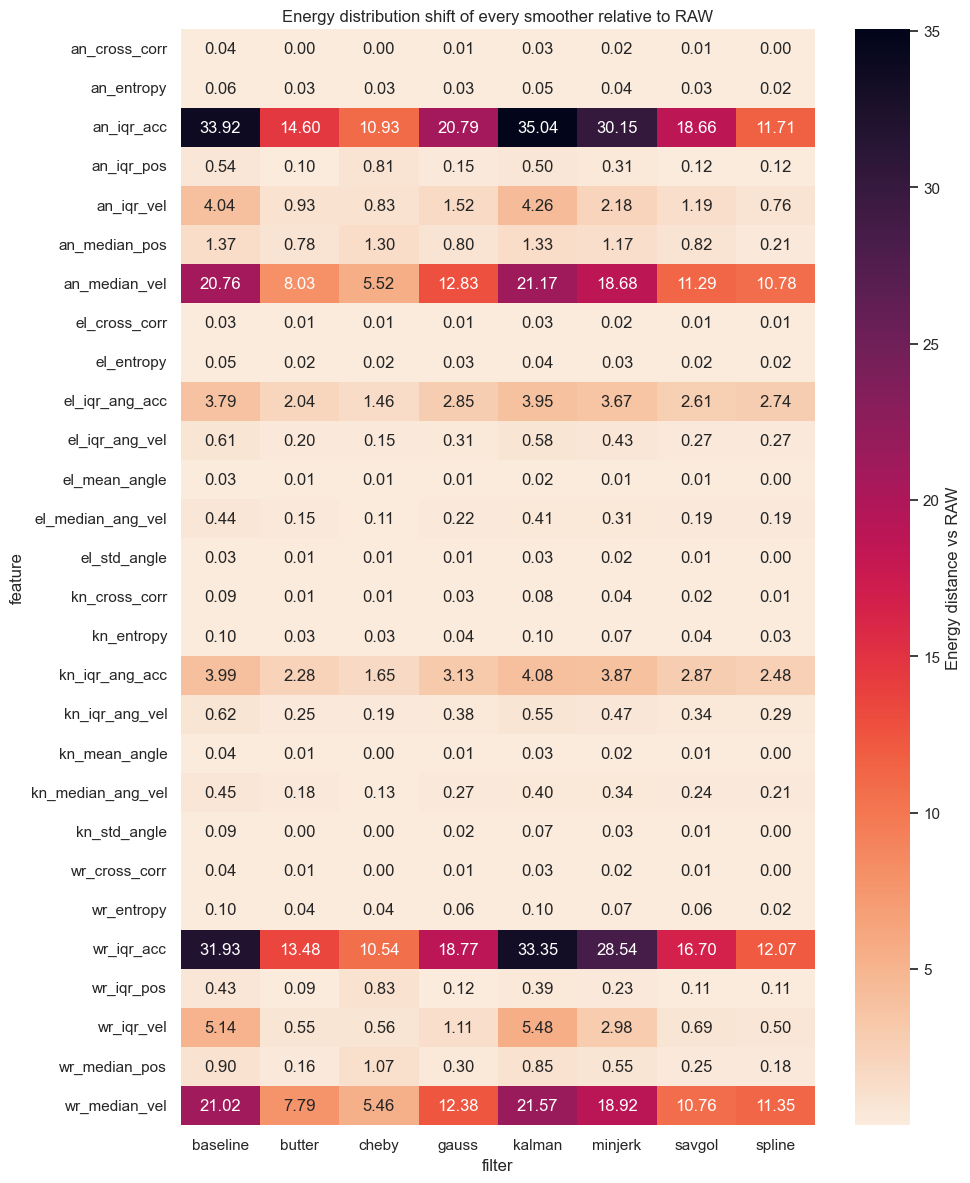

In [209]:
pivot = (shift_multi_df.pivot(index="feature", columns="filter", values="energy")
         .sort_index())

plt.figure(figsize=(10, 12))
sns.heatmap(pivot,
            cmap="rocket_r",
            annot=True,
            fmt=".2f",
            cbar_kws={"label": "Energy distance vs RAW"})
plt.title("Energy distribution shift of every smoother relative to RAW")
plt.tight_layout()

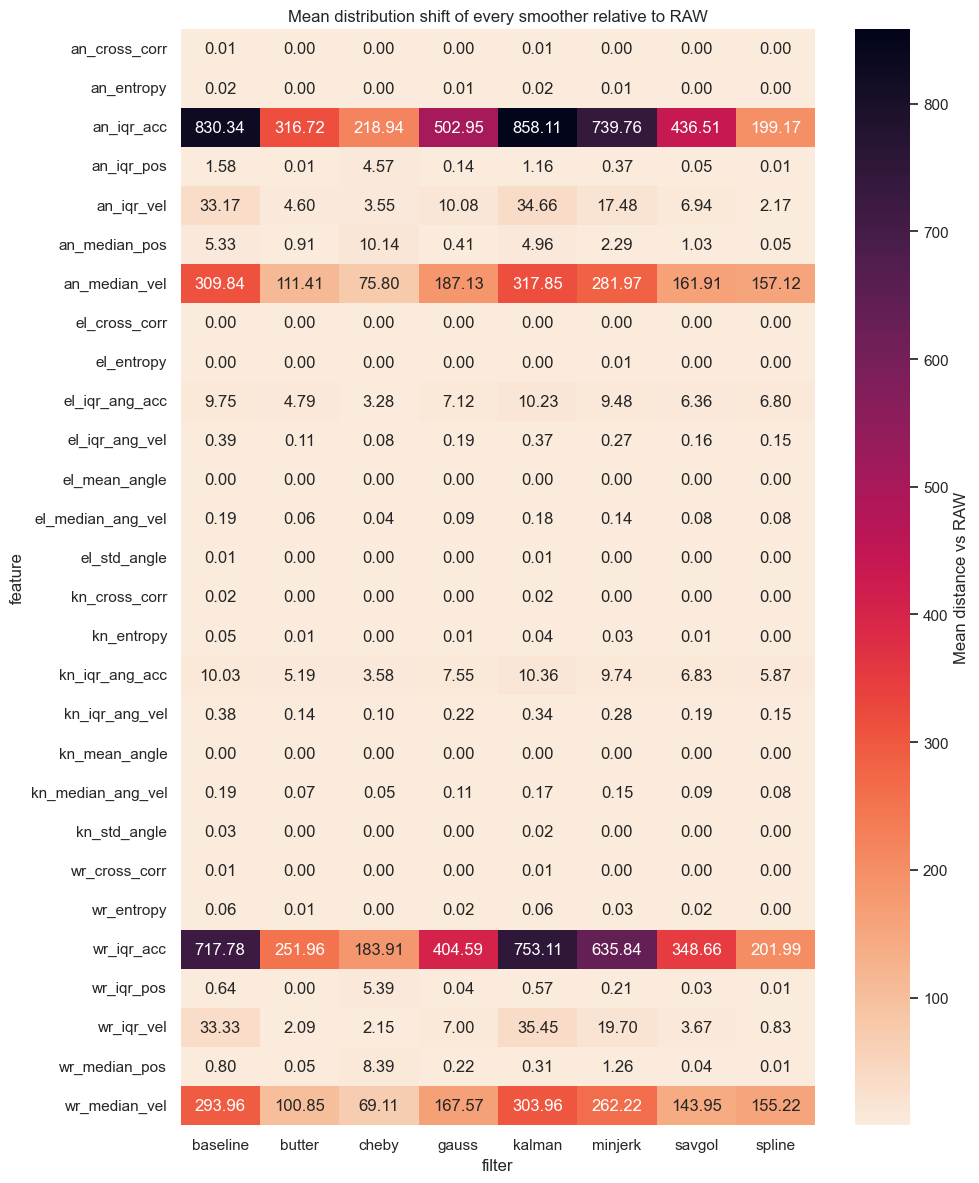

In [210]:
pivot = (shift_multi_df.pivot(index="feature", columns="filter", values="d_mean")
         .sort_index())

plt.figure(figsize=(10, 12))
sns.heatmap(pivot,
            cmap="rocket_r",
            annot=True,
            fmt=".2f",
            cbar_kws={"label": "Mean distance vs RAW"})
plt.title("Mean distribution shift of every smoother relative to RAW")
plt.tight_layout()

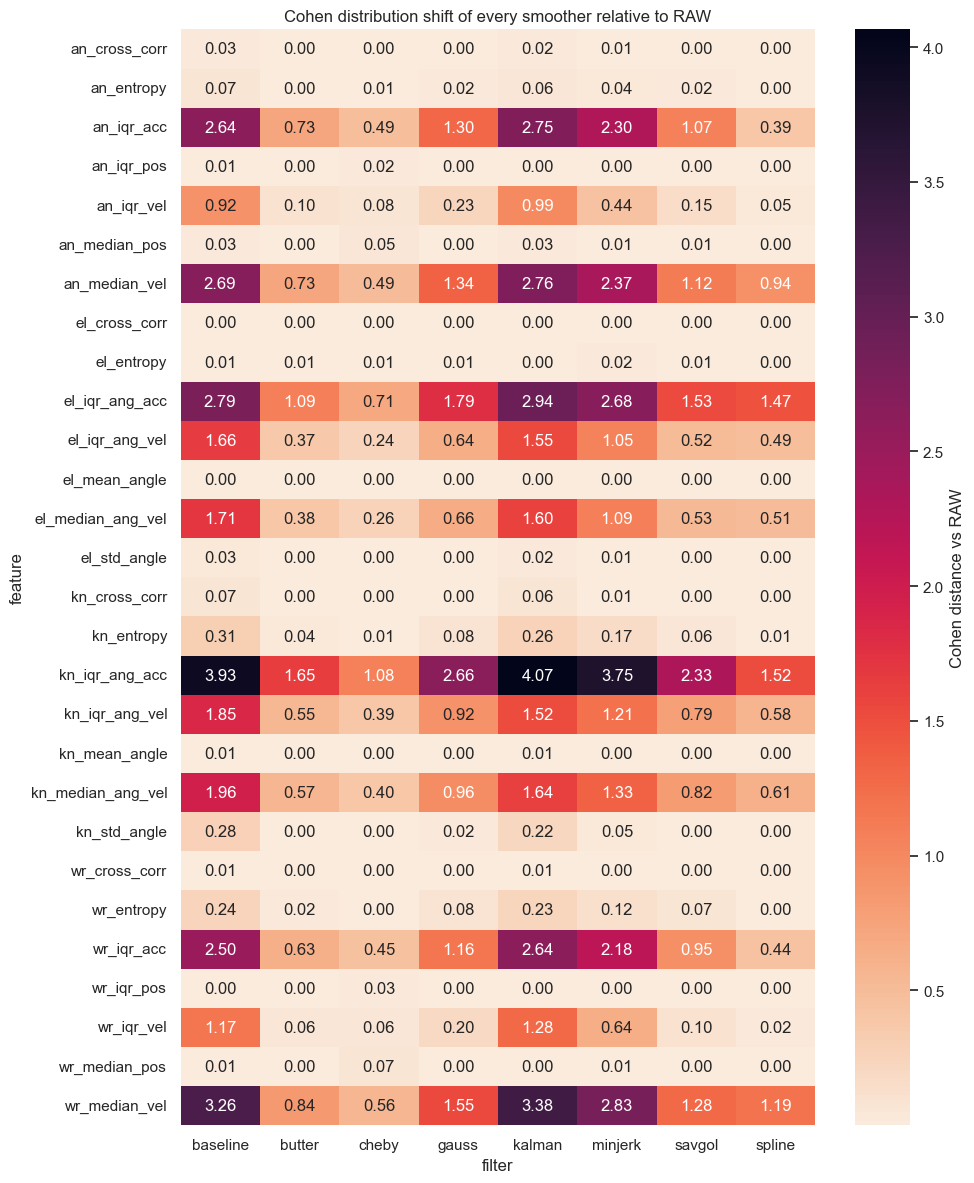

In [211]:
pivot = (shift_multi_df.pivot(index="feature", columns="filter", values="cohen_d")
         .sort_index())

plt.figure(figsize=(10, 12))
sns.heatmap(pivot,
            cmap="rocket_r",
            annot=True,
            fmt=".2f",
            cbar_kws={"label": "Cohen distance vs RAW"})
plt.title("Cohen distribution shift of every smoother relative to RAW")
plt.tight_layout()

C:\Users\ioana\AppData\Local\Temp\ipykernel_25896\576459765.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


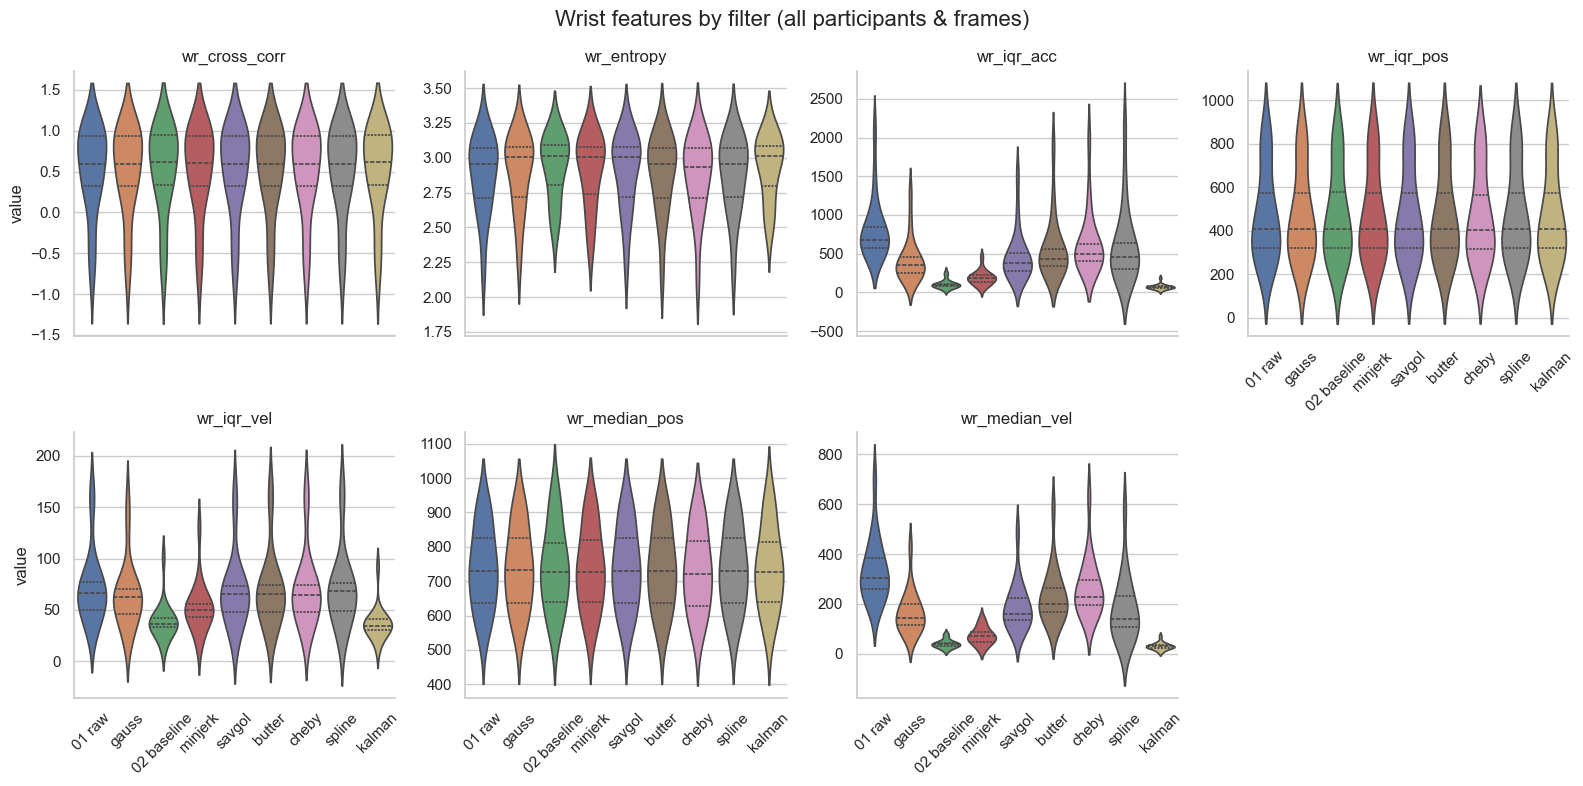

In [215]:
wrist_feats = [c for c in feat_long.columns
               if c.startswith("wr_")]         
plot_long = (
    feat_long
      .replace({"raw": "01 raw", "baseline": "02 baseline"})  # nicer sort-order
      .melt(id_vars=["filter"],          # keep filter as the x-axis category
            value_vars=wrist_feats,
            var_name="feature",
            value_name="value")
)
g = sns.catplot(
        data=plot_long,
        x="filter", y="value",
        col="feature",
        kind="violin", inner="quartile",
        height=4, aspect=1,
        # make them different cool colours
        palette=sns.color_palette("deep", n_colors=len(plot_long["filter"].unique())),
        col_wrap=4,          
        sharey=False)         # each feature gets its own y-scale

g.set_titles("{col_name}")
g.fig.suptitle("Wrist features by filter (all participants & frames)", fontsize=16)
g.set_xlabels("")
g.set_ylabels("value")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

C:\Users\ioana\AppData\Local\Temp\ipykernel_25896\1559802189.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


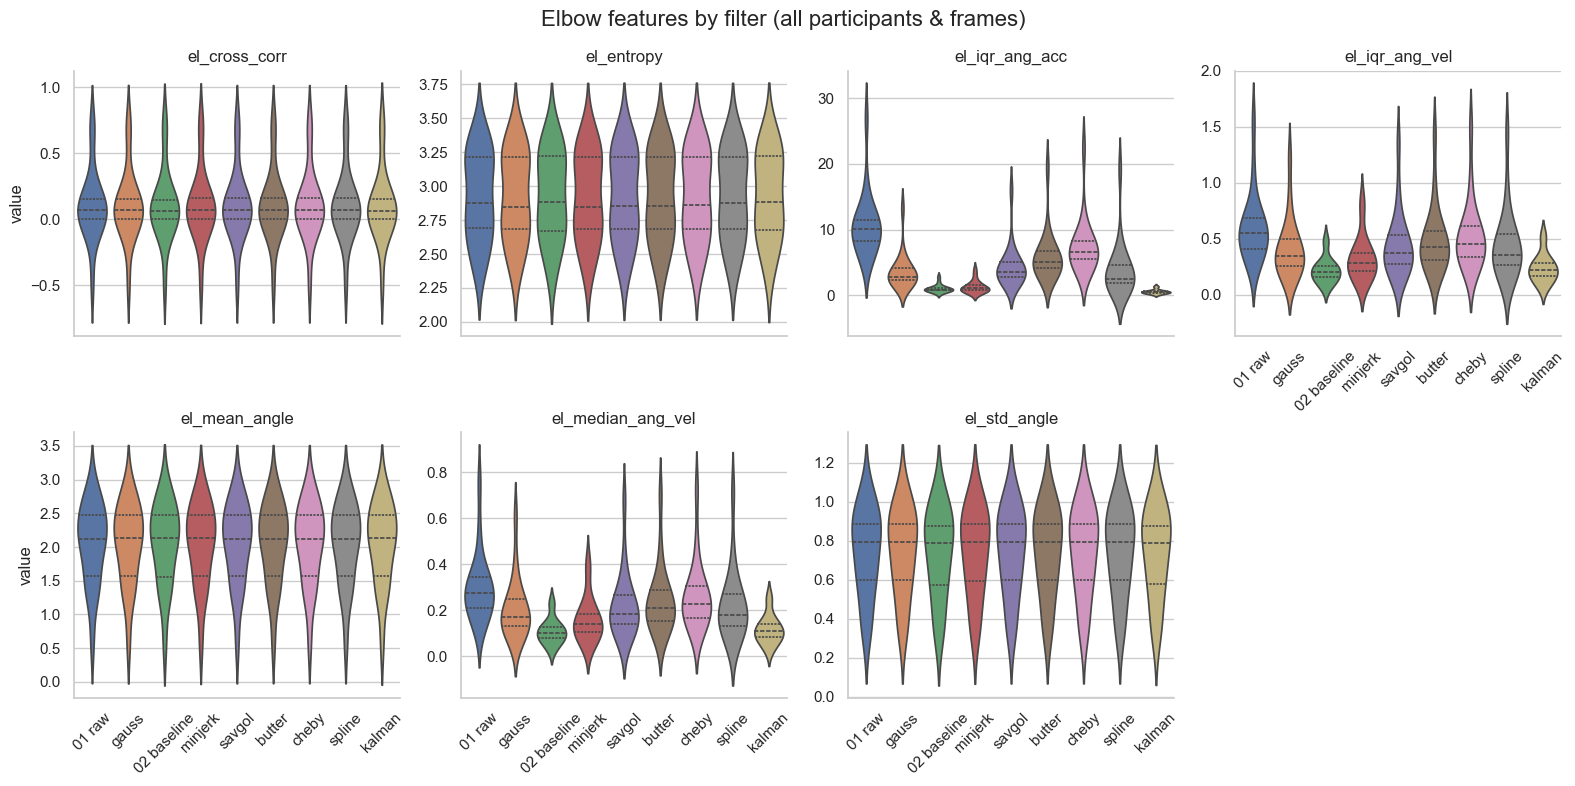

In [214]:
wrist_feats = [c for c in feat_long.columns
               if c.startswith("el_")]         
plot_long = (
    feat_long
      .replace({"raw": "01 raw", "baseline": "02 baseline"})  # nicer sort-order
      .melt(id_vars=["filter"],          # keep filter as the x-axis category
            value_vars=wrist_feats,
            var_name="feature",
            value_name="value")
)
g = sns.catplot(
        data=plot_long,
        x="filter", y="value",
        col="feature",
        kind="violin", inner="quartile",
        height=4, aspect=1,
        # make them different cool colours
        palette=sns.color_palette("deep", n_colors=len(plot_long["filter"].unique())),
        col_wrap=4,          
        sharey=False)         # each feature gets its own y-scale

g.set_titles("{col_name}")
#set titple to elbow features
g.fig.suptitle("Elbow features by filter (all participants & frames)", fontsize=16)
g.set_xlabels("")
g.set_ylabels("value")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

# Displacement of Ankles and Wrists vs smoothing type/ ammount of smoothing

For each wrist (L/R) and ankle (L/R) compute frame-wise displacement

$d_t = \sqrt{(x_t - x_{t-1})^2 + (y_t - t_{t-1})^2}$
 


In [ ]:
filter_fns = {
    "raw"      : lambda x, y, fr: (x, y),
    "baseline" : lambda x, y, fr: (baseline_filter(x), baseline_filter(y)),
    #"gauss"   : lambda x, y, fr: gauss_smooth(x, y),
    "minjerk"  : lambda x, y, fr: (min_jerk_1d(x), min_jerk_1d(y)),
    "savgol"   : lambda x, y, fr: (savgol_filter(x, 11, 3),
                                   savgol_filter(y, 11, 3)),
    "butter"   : lambda x, y, fr: (filtfilt(*butter(4, 5/(0.5*FPS)), x),
                                   filtfilt(*butter(4, 5/(0.5*FPS)), y)),
    "cheby"    : lambda x, y, fr: (filtfilt(*cheby1(4, 0.05, 5/(0.5*FPS)), x),
                                   filtfilt(*cheby1(4, 0.05, 5/(0.5*FPS)), y)),
    "spline"   : lambda x, y, fr: (UnivariateSpline(fr, x, s=None, k=3)(fr),
                                   UnivariateSpline(fr, y, s=None, k=3)(fr)),
    "kalman"   : lambda x, y, fr:  kalman_smooth_xy(x, y)
}
# ================================================================
# LOOP OVER EVERY RECORDING × EVERY FILTER
disp_rows = []
for key, sess in keepers_long.groupby(["participant_id", "date", "camera"]):
    sess = sess.sort_values("frame_id")        # chronological
    for f_name, f_fn in filter_fns.items():
        disp_rows += disp_metrics(sess, f_name, f_fn)

disp_long = pd.DataFrame(disp_rows)

C:\Users\ioana\AppData\Local\Temp\ipykernel_25896\1258316177.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=45)


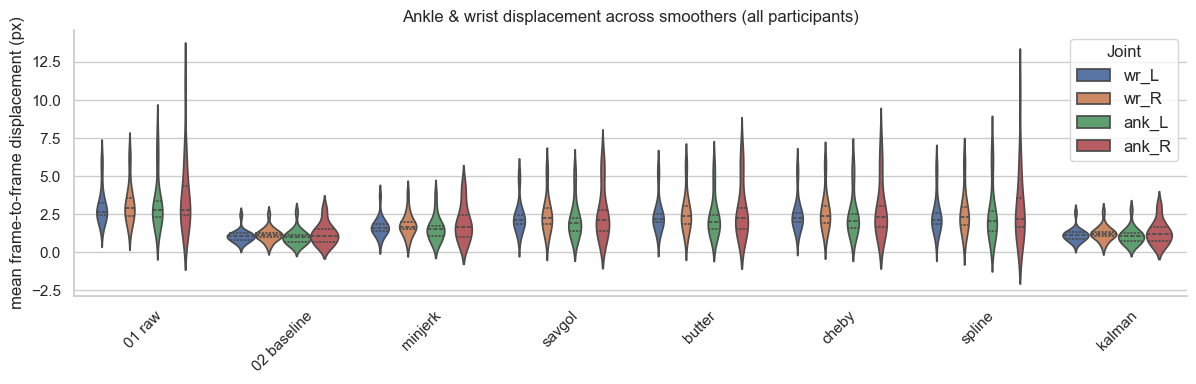

In [ ]:
# ================================================================
# Plot

# nicer ordering of categories
disp_long["filter"] = disp_long["filter"].replace(
        {"raw": "01 raw", "baseline": "02 baseline"})

# create the exact desired order
order = ["01 raw", "02 baseline", 
         "minjerk", "savgol", "butter",
         "cheby", "spline", "kalman"]

# convert to an *ordered* categorical
disp_long["filter"] = pd.Categorical(disp_long["filter"],
                                     categories=order,
                                     ordered=True)
g = sns.catplot(
        data=disp_long,
        x="filter", y="mean_disp",
        hue="joint",
        kind="violin", inner="quartile",
        height=4, aspect=3,
        legend_out=False)

g.set_xlabels(""); g.set_ylabels("mean frame-to-frame displacement (px)")
g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=45)
plt.legend(title="Joint", fontsize=12, loc='upper right')
plt.title("Ankle & wrist displacement across smoothers (all participants)")
plt.tight_layout()

In [61]:
error_rows = []

for key, sess in keepers_long.groupby(["participant_id", "date", "camera"]):
    sess = sess.sort_values("frame_id")
    fr   = sess["frame_id"].to_numpy(dtype=float)

    # -------- raw displacements once, reused for every filter -----
    disp_raw = {}
    for jname, k in JOINTS.items():
        xr, yr = sess[f"x{k}"].to_numpy(), sess[f"y{k}"].to_numpy()
        disp_raw[jname] = np.sqrt(np.diff(xr)**2 + np.diff(yr)**2)  # length n-1

    # -------- loop filters (skip raw itself) ----------------------
    for f_name, f_fn in filter_fns.items():
        if f_name == "raw":
            continue

        for jname, k in JOINTS.items():
            xs, ys = f_fn(sess[f"x{k}"].to_numpy(),
                          sess[f"y{k}"].to_numpy(), fr)

            disp_filt = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2)

            # frame-wise error (aligned: len = n-1)
            delta = disp_filt - disp_raw[jname]

            error_rows.append({
                "participant": key[0],
                "date"       : key[1],
                "camera"     : key[2],
                "filter"     : f_name,
                "joint"      : jname,
                "MAE"        : np.mean(np.abs(delta)),
                "RMSE"       : np.sqrt(np.mean(delta**2)),
                "rho"        : np.corrcoef(disp_raw[jname], disp_filt)[0, 1]
            })

err_sum = pd.DataFrame(error_rows)

In [75]:
# ===== average table (mean ± SD across all recordings) ============
err_table = (err_sum
             .groupby(["filter", "joint"])[["MAE", "RMSE", "rho"]]
             .agg(["mean", "std"])
             .round(3))
print(err_table)

                  MAE          RMSE            rho       
                 mean    std   mean     std   mean    std
filter   joint                                           
baseline ank_L  2.514  1.511  8.219   9.692  0.432  0.168
         ank_R  2.795  1.993  8.932  11.130  0.444  0.188
         wr_L   2.244  1.086  7.112   8.485  0.477  0.183
         wr_R   2.349  1.147  7.660   8.486  0.439  0.197
butter   ank_L  1.448  1.017  5.618   7.246  0.783  0.116
         ank_R  1.559  1.413  6.211   8.793  0.782  0.145
         wr_L   1.054  0.435  4.327   5.438  0.833  0.124
         wr_R   1.094  0.361  4.871   5.561  0.798  0.173
cheby    ank_L  1.376  1.001  5.199   6.741  0.808  0.103
         ank_R  1.488  1.404  5.838   8.403  0.801  0.143
         wr_L   1.005  0.404  3.981   4.808  0.850  0.111
         wr_R   1.041  0.332  4.505   4.960  0.819  0.154
kalman   ank_L  2.409  1.456  8.183   9.783  0.474  0.166
         ank_R  2.667  1.908  8.896  11.215  0.479  0.198
         wr_L 

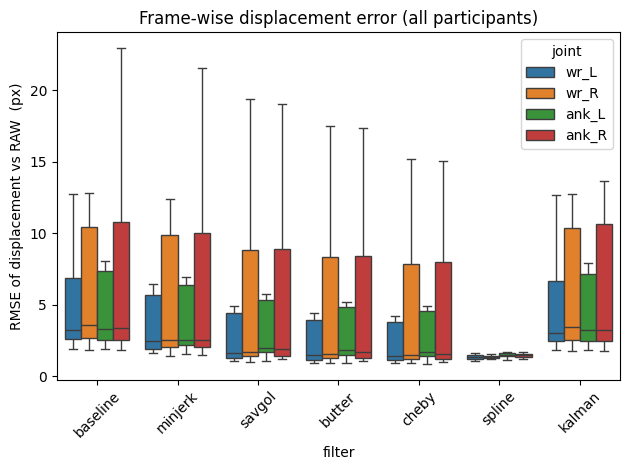

In [76]:
# RMSE Plot 
sns.boxplot(
    data=err_sum,
    x="filter", y="RMSE",
    hue="joint",
    showfliers=False          # ← suppress outlier markers
)

plt.xticks(rotation=45)
plt.ylabel("RMSE of displacement vs RAW  (px)")
plt.title("Frame-wise displacement error (all participants)")
plt.tight_layout()

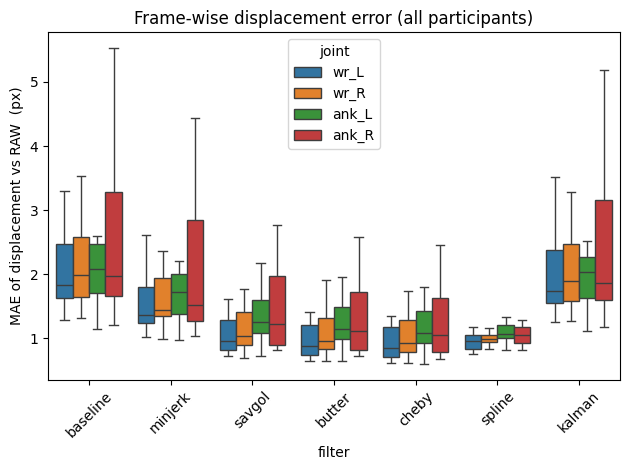

In [ ]:
# MAE Plot 
sns.boxplot(
    data=err_sum,
    x="filter", y="MAE",
    hue="joint",
    showfliers=False          # suppress outlier markers
)

plt.xticks(rotation=45)
plt.ylabel("MAE of displacement vs RAW  (px)")
plt.title("Frame-wise displacement error (all participants)")
plt.tight_layout()

$d_t^{raw}$ and $d_t^{filts}$ are the displacements for the raw and filtered signal at frame t 

The mean is substacted from these time-series to avoid bias, then the 2 time series are cross-correlated 

Then the lags (peak of cross-correlation), are searched for in a +- 3 second window

In [102]:
lag_rows = []

for (pid, date, cam), sess in keepers_long.groupby(
        ["participant_id", "date", "camera"]):

    sess = sess.sort_values("frame_id")
    fr   = sess["frame_id"].to_numpy(dtype=float)

    # displacement of raw once
    disp_raw = {j: np.sqrt(np.diff(sess[f"x{k}"].to_numpy())**2 +
                       np.diff(sess[f"y{k}"].to_numpy())**2)
            for j, k in JOINTS.items()}

    for f_name, f_fn in filter_fns.items():
        if f_name == "raw":
            continue

        for jname, k in JOINTS.items():
            xs, ys = f_fn(sess[f"x{k}"].to_numpy(),
                          sess[f"y{k}"].to_numpy(), fr)

            disp_filt = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2)

            lag_fr, peak_corr = peak_lag(disp_raw[jname], disp_filt)

            lag_rows.append({
                "participant": pid,
                "filter"     : f_name,
                "joint"      : jname,
                "lag_frames" : lag_fr,
                "lag_sec"    : lag_fr / FPS,
                "peak_corr"  : peak_corr
            })

lag_df = pd.DataFrame(lag_rows)

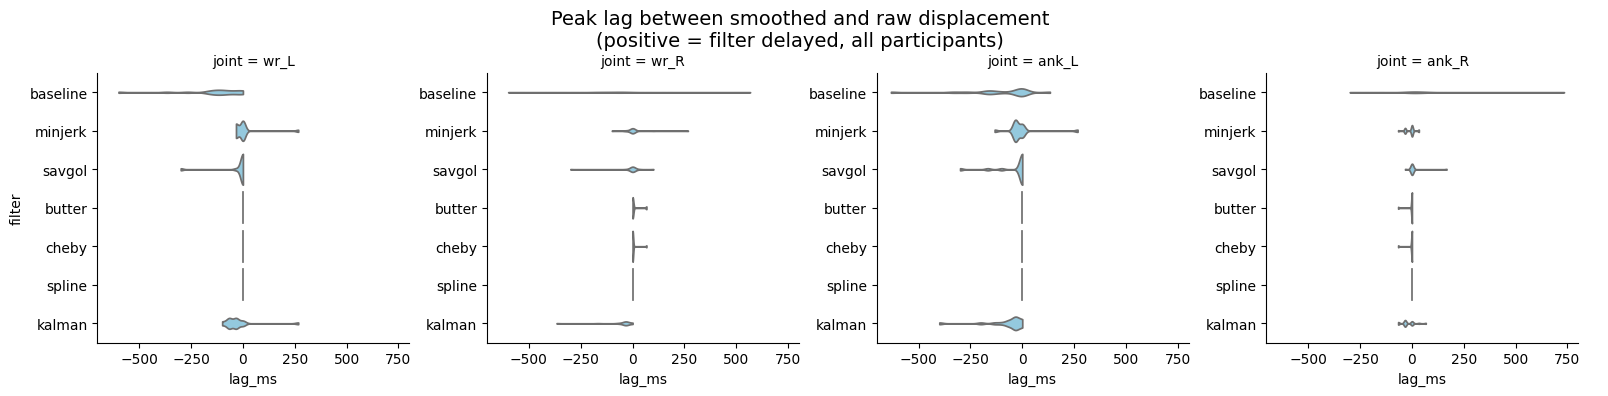

In [ ]:
plot_df = lag_df.copy()
plot_df["lag_ms"] = plot_df["lag_sec"] * 1_000

order = ["baseline", "minjerk", "savgol",
         "butter", "cheby", "spline", "kalman"]
plot_df["filter"] = pd.Categorical(plot_df["filter"],
                                   categories=order, ordered=True)

g = sns.catplot(
        data=plot_df,
        y="filter", x="lag_ms",
        col="joint",
        kind="violin",
        cut=0, bw_adjust=.3,    # replace bw=.3
        inner=None,
        height=4, aspect=1,
        sharex=True, sharey=False,
        color="skyblue")

for ax in g.axes.flatten():
    joint = ax.get_title().split(" = ")[-1]
    sub   = plot_df[plot_df["joint"] == joint]

plt.subplots_adjust(top=0.82, wspace=0.25)
g.fig.suptitle("Peak lag between smoothed and raw displacement\n"
               "(positive = filter delayed, all participants)",
               fontsize=14)
plt.show()

In [ ]:
summary = (lag_df
           .groupby(["filter", "joint"])["lag_sec"]
           .agg(median="median",
                IQR=lambda x: np.subtract(*np.percentile(x, [75, 25])),
                n="count")
           .round(3))
print(summary)

In [ ]:
# --------------------------------------------------------------
#  main loop: one row = recording × filter × window × joint
# --------------------------------------------------------------
rows = []
for (pid, date, cam), sess in tqdm(
        keepers_long.groupby(["participant_id", "date", "camera"]),
        desc="sessions"):
    sess = sess.sort_values("frame_id")
    fr   = sess["frame_id"].to_numpy(dtype=float)

    # ---------- raw (reference) ----------
    disp_raw = { (j, L):
                 lagged_disp(sess[f"x{k}"].to_numpy(),
                             sess[f"y{k}"].to_numpy(), L)
                 for j, k in JOINTS.items() for L in WINDOW_FR }

    # ---------- loop smoothers ----------
    for f_name, f_fn in filter_fns.items():
        if f_name == "raw":          # skip self-comparison
            continue

        for jname, k in JOINTS.items():
            xs, ys = f_fn(sess[f"x{k}"].to_numpy(),
                          sess[f"y{k}"].to_numpy(), fr)

            for L in WINDOW_FR:
                d_filt = lagged_disp(xs, ys, L)
                d_raw  = disp_raw[(jname, L)]
                err    = d_filt - d_raw

                rows.append({
                    "participant": pid,
                    "date"      : date,
                    "camera"    : cam,
                    "filter"    : f_name,
                    "joint"     : jname,
                    "window_s"  : L / FPS,          # 1,2,3
                    "MAE"       : np.mean(np.abs(err)),
                    "RMSE"      : np.sqrt(np.mean(err**2))
                })

err_win = pd.DataFrame(rows)

# nicer ordering
cat_order = ["raw", "baseline", "minjerk", "savgol",
             "butter", "cheby", "spline", "kalman"]

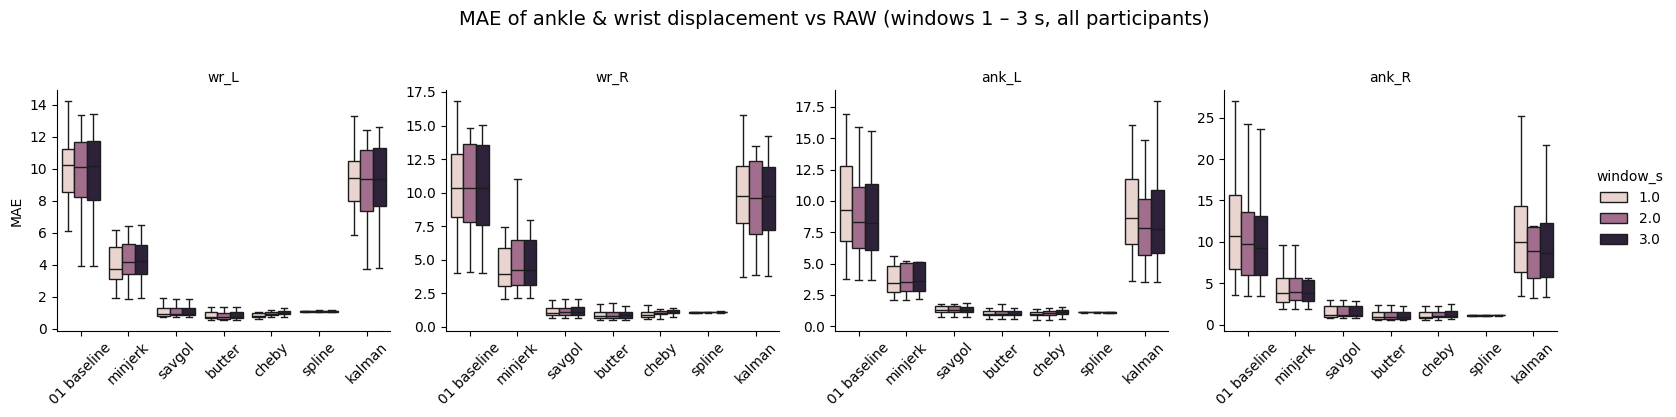

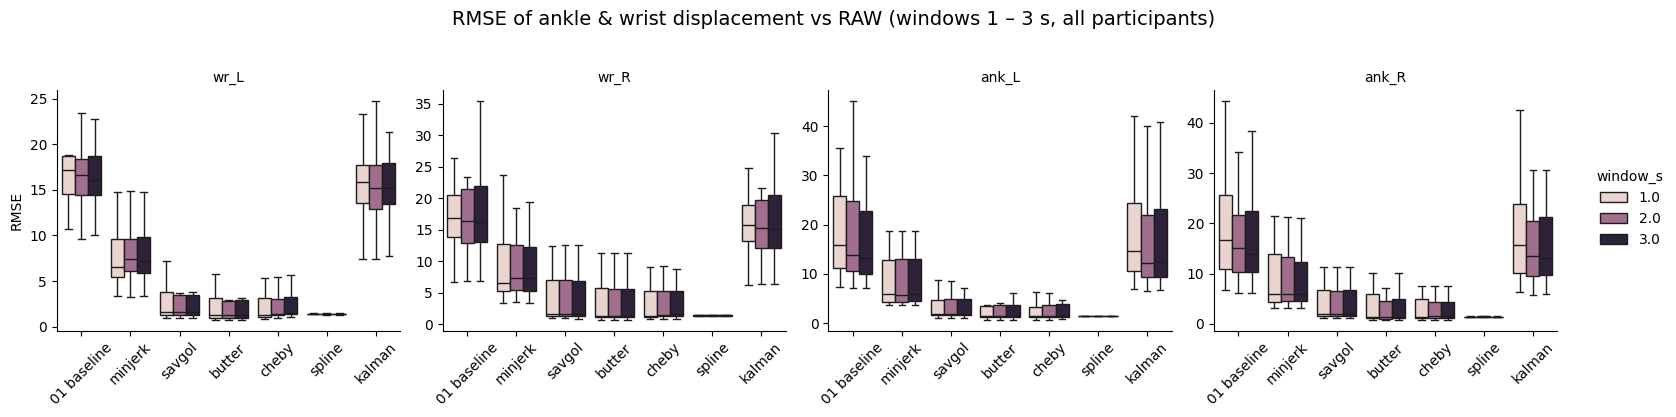

In [ ]:
rename_map = {"raw": "00 raw", "baseline": "01 baseline"}   # put them first
err_win["filter"] = err_win["filter"].replace(rename_map)

# full preferred sequence
preferred = ["00 raw", "01 baseline",
             "minjerk", "savgol", "butter",
             "cheby", "spline", "kalman"]

# keep only the labels that really exist in the data
order = [lab for lab in preferred if lab in err_win["filter"].unique()]

# set as an *ordered* categorical (no mismatch now)
err_win["filter"] = pd.Categorical(err_win["filter"],
                                   categories=order,
                                   ordered=True)

# ──────────────────────────────────────────────────────────────
# box-plots (outliers hidden)
# ──────────────────────────────────────────────────────────────
for metric in ["MAE", "RMSE"]:

    g = sns.catplot(
            data=err_win,
            x="filter", y=metric,
            hue="window_s", col="joint",
            kind="box",          showfliers=False,
            height=4, aspect=1,  sharey=False,
            legend = 'auto')        # ← suppress per-axis legend

    # prettier axes
    g.set_xlabels("")
    g.set_titles("{col_name}")
    for ax in g.axes.flatten():
        ax.tick_params(axis="x", rotation=45)

    # ── single legend for the whole figure ──────────────────────
    # grab handles & labels from *one* subplot
    handles, labels = g.axes[0][0].get_legend_handles_labels()

    # overall title
    g.fig.suptitle(f"{metric} of ankle & wrist displacement vs RAW "
                   "(windows 1 – 3 s, all participants)",
                   y=1.03, fontsize=14)

    plt.tight_layout(rect=[0, 0, 0.94, 1])   # leave space at right for legend

# Displacement of Ankles and Wrists vs ammount of smoothing - Spline

s is a global roughness penalty

In [155]:
def spline_loocv_s(fr, sig):
    """Return (s_used, RMS residual) chosen by UnivariateSpline(s=None)."""
    spl = UnivariateSpline(fr, sig, s=None, k=3)
    # SciPy stores the chosen s in spl.get_residual()  (sum of squared residuals)
    s_used = spl.get_residual()          # this *is* the internal s
    resid  = np.sqrt(s_used / len(fr))   # RMS residual in px
    return s_used, resid

s_vals = []
for (_, _, _), sess in keepers_long.groupby(["participant_id","date","camera"]):
    fr  = sess["frame_id"].to_numpy(dtype=float)
    x0  = sess["x9"].to_numpy()          # e.g. left wrist
    s, rms = spline_loocv_s(fr, x0)
    s_vals.append(s)

n   = len(fr)                # e.g. 7 500 frames
var = x0.var()               # say  500 px²
varN = var * n 

print("min s:", min(s_vals), "max s:", max(s_vals))
print("var x N:", varN)

min s: 3686.6813950187616 max s: 9209.093667149633
var x N: 6461464.37336833


In [167]:
S_FACTORS = [0,
             0.0003, 0.0004, 0.0005, 0.0006, 0.0007,
             0.0008, 0.0009, 0.0010, 0.0011, 0.0012, 0.0013, 0.0014]

def spline_filter_factory(s_frac):
    """Return a (x,y,fr) smoother with s = s_frac · var · N."""
    def smoother(x, y, fr):
        n  = len(x)
        sx = s_frac * x.var() * n
        sy = s_frac * y.var() * n
        xs = UnivariateSpline(fr, x, s=sx, k=3)(fr)
        ys = UnivariateSpline(fr, y, s=sy, k=3)(fr)
        return xs, ys
    return smoother

spline_filters = {s: spline_filter_factory(s) for s in S_FACTORS}

In [ ]:
rows = []
for (pid, date, cam), sess in tqdm(
        keepers_long.groupby(["participant_id", "date", "camera"]),
        desc="sessions"):
    sess = sess.sort_values("frame_id")
    fr   = sess["frame_id"].to_numpy(dtype=float)

    # raw displacements once
    disp_raw = {j: np.sqrt(np.diff(sess[f"x{k}"])**2 +
                           np.diff(sess[f"y{k}"])**2)
                for j, k in JOINTS.items()}

    # loop smoothing factors
    for s_frac, f_fn in spline_filters.items():
        for jname, k in JOINTS.items():
            xs, ys = f_fn(sess[f"x{k}"].to_numpy(),
                          sess[f"y{k}"].to_numpy(), fr)
            disp_f = np.sqrt(np.diff(xs)**2 + np.diff(ys)**2)
            delta  = disp_f - disp_raw[jname]

            rows.append({
                "participant": pid,
                "s_frac"    : s_frac,
                "joint"     : jname,
                "RMSE"      : np.sqrt(np.mean(delta**2)),
                "MAE"       : np.mean(np.abs(delta)),
                "ratio"     : disp_f.mean() / disp_raw[jname].mean()
            })

spline_err = pd.DataFrame(rows)

sessions: 100%|██████████| 18/18 [02:38<00:00,  8.78s/it]


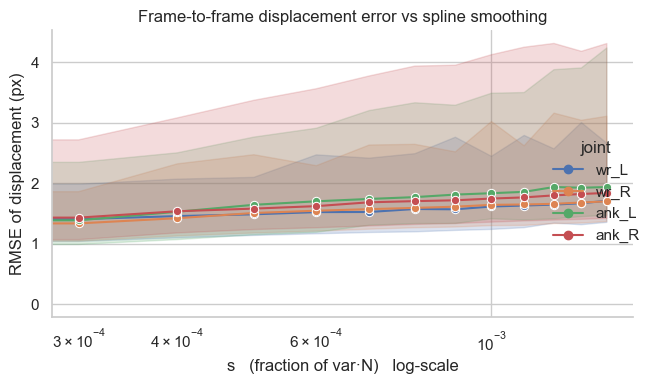

In [169]:
sns.relplot(
    data=spline_err,
    x="s_frac", y="RMSE",
    hue="joint",
    kind="line", marker="o",
    estimator="median",
    errorbar=("pi", 90),          # 90 % prediction interval
    height=4, aspect=1.4)

plt.gca().set_xscale("log")       # log axis makes tiny s clearer
plt.xlabel("s   (fraction of var·N)   log-scale")
plt.ylabel("RMSE of displacement (px)")
plt.title("Frame-to-frame displacement error vs spline smoothing")
plt.tight_layout()

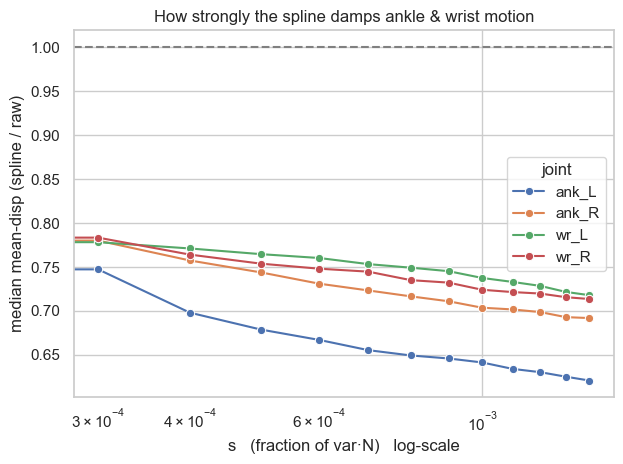

In [170]:
suppress = (spline_err
            .groupby(["s_frac", "joint"])["ratio"]
            .median()
            .reset_index())

sns.lineplot(
    data=suppress,
    x="s_frac", y="ratio",
    hue="joint", marker="o")

plt.gca().set_xscale("log")
plt.axhline(1, ls="--", color="gray")
plt.ylabel("median mean-disp (spline / raw)")
plt.xlabel("s   (fraction of var·N)   log-scale")
plt.title("How strongly the spline damps ankle & wrist motion")
plt.tight_layout()